# Libraries

In [1]:
import collections
import copy
import itertools
import json
import logging
# Imports and setup
import os
from collections import defaultdict
from datetime import datetime
from pathlib import Path

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from torch_geometric.data import Data, DataLoader
from torch_geometric.loader import DataLoader
from torch_geometric.nn import GATv2Conv
from torch_geometric.utils import to_dense_adj, k_hop_subgraph
from tqdm.notebook import tqdm

In [2]:
import warnings
from Bio.PDB.PDBExceptions import PDBConstructionWarning

# Suppress PDB warnings globally
warnings.simplefilter('ignore', PDBConstructionWarning)

from preprocessing_v3 import ProteinAnalyzer, process_pdb_directory
#from utils_ln import load_aa_info  # Or define `load_aa_info` in the same script

# Configuration

In [3]:
# Configure logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

# Set environment variable for MPS fallback
os.environ['PYTORCH_ENABLE_MPS_FALLBACK'] = '1'

# Set plot style
sns.set_theme()

# Device setup
def get_device():
    """Get the best available device with fallbacks"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    elif torch.backends.mps.is_available():
        logger.info("MPS (M1/M2) device found but using CPU for some operations due to compatibility")
        return torch.device('cpu')
    return torch.device('cpu')

def compute_average_edges(data_loader):
    """
    Compute the average number of edges and nodes in the dataset
    """
    total_edges = 0
    total_nodes = 0
    num_graphs = 0

    for batch in data_loader:
        total_edges += batch.edge_index.size(1) // 2  # Divide by 2 for undirected edges
        total_nodes += batch.x.size(0)
        num_graphs += 1

    return {
        'avg_edges': total_edges / num_graphs,
        'avg_nodes': total_nodes / num_graphs,
        'avg_backbone': total_nodes / num_graphs - 1  # One less than nodes
    }

# Paths and constants

In [4]:
# Define the file for a demo protein structure
pdb_file = 'data/all_nano_structures_single_domain/1zv5.pdb'

# Define the directory containing the PDB files
pdb_directory = 'data/all_nano_structures_single_domain'

# Define the file containing amino acid information
aa_info_file = 'aa_mass_letter.csv'

# Preprocessed protein dataframes 
output_dir = "processed_dataframes"

# Preprocessing

In [5]:
# Load amino acid information
aa_info = pd.read_csv(aa_info_file)
aa_info['Abbrev.'] = aa_info['Abbrev.'].apply(lambda x: x.upper())
aa_info_dict = aa_info.set_index('Abbrev.').to_dict(orient='index')
#aa_info_dict

In [6]:
# Process PDB directory
dataframes = process_pdb_directory(pdb_directory, aa_info_dict, neighborhood_radius=5.0)


Processing PDBs: 100%|██████████| 1636/1636 [08:46<00:00,  3.11it/s]


In [7]:
dataframes[30]

('data/all_nano_structures_single_domain/6rbb.pdb',
              X          Y       Z   Avg_Mass  Avg_Neighbor_Dist  \
 0     0.694000  -4.277000   5.308  174.20274           3.721274   
 1    -2.990000  -4.576000   5.740   75.06714           4.198928   
 2    -6.508000  -3.784000   4.701  105.09344           3.805953   
 3    -8.875000  -3.795000   7.749  147.13074           3.833386   
 4    -6.175000  -5.348000   9.939  165.19184           3.788165   
 ..         ...        ...     ...        ...                ...   
 478 -33.832001 -20.900999  10.996  117.14784           4.169421   
 479 -33.150002 -18.483999   8.138  119.12034           4.082392   
 480 -34.498001 -14.935000   8.444  117.14784           4.093996   
 481 -34.692001 -12.858000   5.268  105.09344           4.145524   
 482 -34.766998  -9.058000   5.304  105.09344           3.800911   
 
      Max_Neighbor_Dist  Neighbor_Count  Small_Molecules_Found  
 0             3.721274               1                      1  


In [8]:
import os

# Directory to store processed DataFrames
os.makedirs(output_dir, exist_ok=True)

# Save each DataFrame to a pickle file
for pdb_file, df in dataframes:
    pdb_id = os.path.basename(pdb_file).replace('.pdb', '')  # Extract PDB ID from filename
    df.to_pickle(os.path.join(output_dir, f"{pdb_id}.pkl"))

print(f"DataFrames saved in {output_dir} as pickle files")


DataFrames saved in processed_dataframes as pickle files


# Graph conversion

In [9]:
import numpy as np
import torch
from torch_geometric.data import Data
from sklearn.neighbors import NearestNeighbors

def nanobody_to_graph(df, k=10, include_coordinates=True):
    """
    Convert a nanobody DataFrame into a graph for GTA-based GNNs.

    Parameters:
    - df: DataFrame containing nanobody data.
    - k: Number of nearest neighbors for graph connectivity.
    - include_coordinates: Whether to include 3D coordinates in node features.

    Returns:
    - PyTorch Geometric Data object.
    """
    # Step 1: Node Features
    features_to_include = ['Avg_Mass', 'Avg_Neighbor_Dist', 'Max_Neighbor_Dist', 'Neighbor_Count', 'Small_Molecules_Found']
    node_features = df[features_to_include].values

    # Optionally include coordinates in node features
    if include_coordinates:
        coords = df[['X', 'Y', 'Z']].values
        node_features = np.hstack([node_features, coords])

    # Convert to tensor
    node_features = torch.tensor(node_features, dtype=torch.float)

    # Step 2: KNN-based Edge Construction
    coords = df[['X', 'Y', 'Z']].values
    nbrs = NearestNeighbors(n_neighbors=k, algorithm='ball_tree').fit(coords)
    distances, indices = nbrs.kneighbors(coords)

    edge_index = []
    edge_attr = []
    for i in range(len(indices)):
        for j in range(1, k):  # Skip self-loop (j=0)
            edge_index.append([i, indices[i, j]])
            edge_attr.append([distances[i, j]])

    edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()
    edge_attr = torch.tensor(edge_attr, dtype=torch.float)

    # Step 3: Create Graph Data Object
    data = Data(
        x=node_features,      # Node features
        edge_index=edge_index,  # Edges
        edge_attr=edge_attr,   # Edge features (distances)
    )
    return data


In [10]:
graphs = []  # Define `graphs` outside the loop
for pdb_file, df in tqdm(dataframes, desc="Processing", unit="graph", bar_format="{l_bar}{bar}| {n_fmt}/{total_fmt} [{elapsed}<{remaining}]"):
    graph = nanobody_to_graph(df, k=5, include_coordinates=True)
    graphs.append((pdb_file, graph))


Processing:   0%|          | 0/1636 [00:00<?]

# Graph representation vs reality

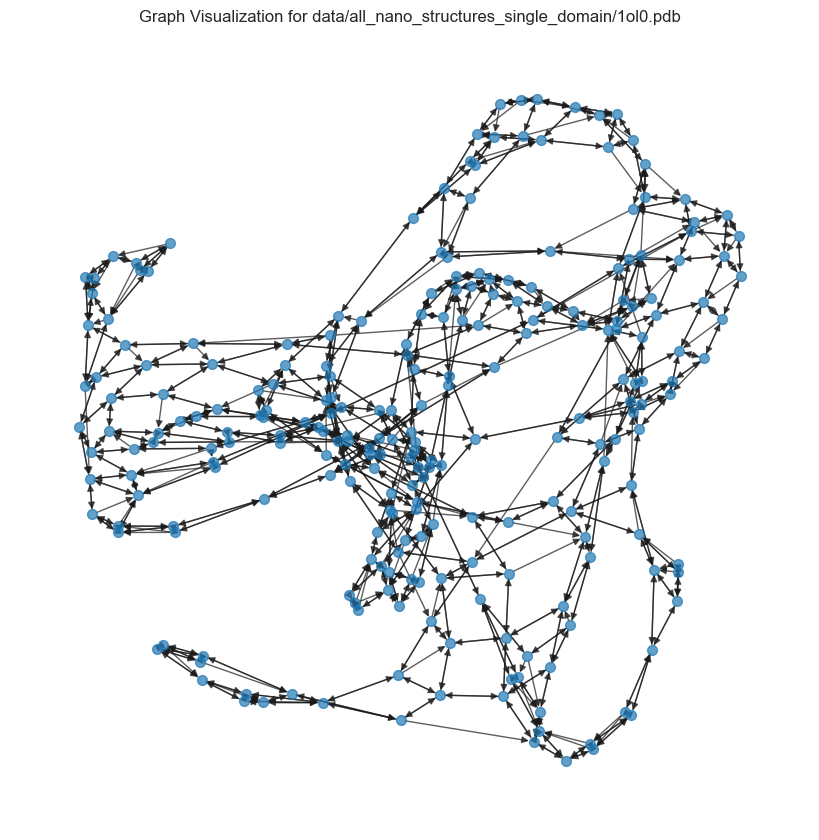

In [11]:
import networkx as nx
from torch_geometric.utils import to_networkx
import matplotlib.pyplot as plt

def visualize_nanobody_graph(data, pdb_file):
    """Visualize the nanobody graph."""
    G = to_networkx(data, edge_attrs=['edge_attr'], node_attrs=['x'])
    pos = nx.spring_layout(G, seed=42)
    plt.figure(figsize=(8, 8))
    nx.draw(G, pos, with_labels=False, node_size=50, alpha=0.7)
    plt.title(f"Graph Visualization for {pdb_file}")
    plt.show()

# Example
pdb_file, data = graphs[10]
visualize_nanobody_graph(data, pdb_file)


In [12]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import networkx as nx
from torch_geometric.utils import to_networkx

# Define amino acid masses and their corresponding colors
AMINO_ACID_DATA = [
    (89.09404, "Alanine", "blue"),
    (121.15404, "Cysteine", "green"),
    (133.10384, "Aspartic acid", "red"),
    (147.13074, "Glutamic acid", "cyan"),
    (165.19184, "Phenylalanine", "magenta"),
    (75.06714, "Glycine", "yellow"),
    (155.15634, "Histidine", "orange"),
    (131.17464, "Isoleucine/Leucine", "purple"),
    (146.18934, "Lysine", "brown"),
    (149.20784, "Methionine", "pink"),
    (132.11904, "Asparagine", "lime"),
    (255.31000, "Pyrrolysine", "gold"),
    (115.13194, "Proline", "silver"),
    (146.14594, "Glutamine", "teal"),
    (174.20274, "Arginine", "coral"),
    (105.09344, "Serine", "navy"),
    (119.12034, "Threonine", "olive"),
    (168.05300, "Selenocysteine", "maroon"),
    (117.14784, "Valine", "black"),
    (204.22844, "Tryptophan", "violet"),
    (181.19124, "Tyrosine", "gray"),
]

# Convert amino acid data to lookup tables
MASS_TO_COLOR = {mass: color for mass, _, color in AMINO_ACID_DATA}
MASS_TO_NAME = {mass: name for mass, name, _ in AMINO_ACID_DATA}

def map_mass_to_color(mass):
    """Find the closest amino acid mass and return its color."""
    closest_mass = min(MASS_TO_COLOR.keys(), key=lambda m: abs(m - mass))
    return MASS_TO_COLOR[closest_mass]

def visualize_nanobody_graph_aminoacids(data, pdb_file):
    """
    Visualize a nanobody graph with amino acid-specific colors.

    Parameters:
    - data: PyTorch Geometric Data object.
    - pdb_file: Name of the nanobody structure file.
    """
    # Convert to NetworkX graph
    G = to_networkx(data, edge_attrs=['edge_attr'], node_attrs=['x'])

    # Use a layout (try 'spring', 'kamada_kawai', or others)
    pos = nx.spring_layout(G, seed=42)

    # Map nodes to amino acid colors using Avg_Mass (x[0])
    node_colors = [
        map_mass_to_color(node[1]['x'][0]) for node in G.nodes(data=True)
    ]

    # Scale node sizes dynamically (e.g., based on Neighbor_Count, x[3])
    node_sizes = [max(10, node[1]['x'][3] * 50) for node in G.nodes(data=True)]  # Assuming Neighbor_Count is x[3]

    # Scale edge widths dynamically based on edge distances (edge_attr)
    edge_weights = [max(0.1, edge[2]['edge_attr'][0]) for edge in G.edges(data=True)]

    # Create the figure and axes explicitly
    fig, ax = plt.subplots(figsize=(10, 10))

    # Draw the graph
    nx.draw(
        G,
        pos,
        ax=ax,  # Explicitly set the axes for the graph
        with_labels=False,
        node_color=node_colors,
        node_size=node_sizes,
        edge_color='gray',  # Static edge color for better node visibility
        width=edge_weights,
        alpha=0.9  # Transparency for better visibility
    )

    # Add a legend for amino acid colors
    legend_patches = [
        mpl.patches.Patch(color=color, label=name)
        for _, name, color in AMINO_ACID_DATA
    ]
    ax.legend(handles=legend_patches, loc='upper left', fontsize=8, title="Amino Acids")

    # Add a title
    ax.set_title(f"Graph Visualization for {pdb_file}", fontsize=14)
    plt.show()


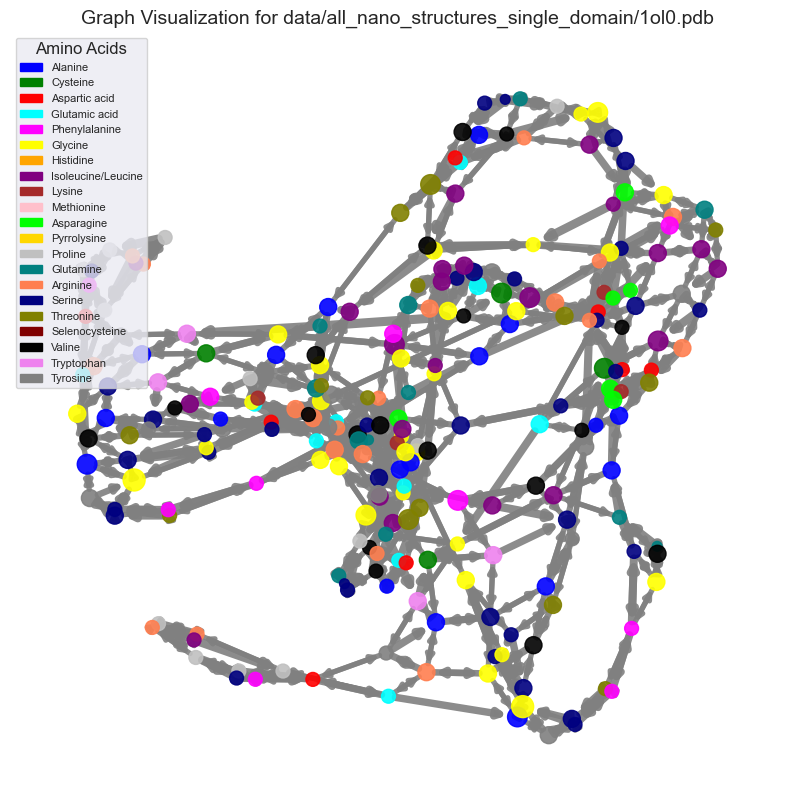

In [13]:
# Example
pdb_file, data = graphs[10]
visualize_nanobody_graph_aminoacids(data, pdb_file)

In [14]:
# from IPython.display import display
# from PIL import Image
# import matplotlib.pyplot as plt

# # Paths to your images
# image_path_1 = "data/mab_dataset/3sn6.png"
# image_path_2 = "data/mab_dataset/3sn6_plot.png"

# # Open the images using PIL
# image_1 = Image.open(image_path_1)
# image_2 = Image.open(image_path_2)

# # Create a matplotlib figure
# fig, axes = plt.subplots(1, 2, figsize=(15, 8))  # 1 row, 2 columns

# # Display the first image
# axes[0].imshow(image_1)
# axes[0].axis('off')  # Hide axes
# axes[0].set_title("Image 1: Original")

# # Display the second image
# axes[1].imshow(image_2)
# axes[1].axis('off')  # Hide axes
# axes[1].set_title("Image 2: Plot")

# # Show the images
# plt.tight_layout()
# plt.show()


# Dataloader

In [15]:
# from torch_geometric.loader import DataLoader
# from sklearn.model_selection import train_test_split

# def split_and_batch_graphs(graphs, batch_size=8, train_ratio=0.8, seed=42):
#     """
#     Split the graphs into train and test datasets, and create DataLoaders for batching.

#     Parameters:
#     - graphs (list): List of `torch_geometric.data.Data` graphs.
#     - batch_size (int): Batch size for the DataLoader.
#     - train_ratio (float): Proportion of data to use for training.
#     - seed (int): Random seed for reproducibility.

#     Returns:
#     - train_loader (DataLoader): DataLoader for the training set.
#     - test_loader (DataLoader): DataLoader for the testing set.
#     """
#     # Set random seed for reproducibility
#     torch.manual_seed(seed)
    
#     # Split into train and test sets
#     train_graphs, test_graphs = train_test_split(graphs, train_size=train_ratio, random_state=seed)
    
#     # Create DataLoaders
#     train_loader = DataLoader(train_graphs, batch_size=batch_size, shuffle=True)
#     test_loader = DataLoader(test_graphs, batch_size=batch_size, shuffle=False)
    
#     return train_loader, test_loader


In [16]:
# # Unpack graphs
# graph_data = [graph for _, graph in graphs]  # Extract only the `Data` objects

# # Split and batch the graphs
# train_loader, test_loader = split_and_batch_graphs(graph_data, batch_size=16, train_ratio=0.8, seed=42)

# # Optional: Keep file names for reference
# pdb_files = [pdb_file for pdb_file, _ in graphs]

# # Example: Iterate through training batches
# for batch in train_loader:
#     print(batch)  # This should now work as expected


# GTA VAE Alex V10

In [61]:
import torch
from torch_geometric.data import Data, DataLoader
from sklearn.model_selection import train_test_split
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GATConv, global_mean_pool
from torch_geometric.data import Data, DataLoader
import matplotlib.pyplot as plt

def prepare_graphs_for_vae(graph_tuples, batch_size=16, train_ratio=0.8, shuffle=True):
    """
    Prepare PDB graph data for VAE training with normalization
    """
    # Extract PyG Data objects
    graphs = [g[1] for g in graph_tuples]

    # Calculate normalization statistics across all graphs
    all_features = torch.cat([g.x for g in graphs], dim=0)
    feature_means = all_features.mean(dim=0)
    feature_stds = all_features.std(dim=0)

    # Prevent division by zero
    feature_stds = torch.where(feature_stds == 0, torch.ones_like(feature_stds), feature_stds)

    # Normalize all graphs
    for graph in graphs:
        graph.x = (graph.x - feature_means) / feature_stds

        # Also normalize edge attributes (distances)
        if graph.edge_attr is not None:
            edge_mean = graph.edge_attr.mean()
            edge_std = graph.edge_attr.std()
            if edge_std > 0:
                graph.edge_attr = (graph.edge_attr - edge_mean) / edge_std

    # Rest of your existing function...
    train_graphs, test_graphs = train_test_split(
        graphs,
        train_size=train_ratio,
        shuffle=shuffle,
        random_state=42
    )

    train_loader = DataLoader(
        train_graphs,
        batch_size=batch_size,
        shuffle=shuffle
    )

    test_loader = DataLoader(
        test_graphs,
        batch_size=batch_size,
        shuffle=False
    )

    sample_data = train_graphs[0]
    in_channels = sample_data.x.size(1)

    print(f"Dataset prepared:")
    print(f"Number of training graphs: {len(train_graphs)}")
    print(f"Number of test graphs: {len(test_graphs)}")
    print(f"Number of features per node: {in_channels}")
    print(f"Feature means:", feature_means)
    print(f"Feature stds:", feature_stds)

    # Return normalization parameters for later use (e.g., inference)
    return train_loader, test_loader, in_channels, (feature_means, feature_stds)

def setup_and_train_vae(graph_tuples, batch_size=16, hidden_channels=64, latent_channels=32, num_heads=4, num_epochs=100):
    """
    Set up the VAE and start training with attention-based handling of variable-sized graphs
    """
    # Set up device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")

    # Prepare data
    train_loader, test_loader, in_channels = prepare_graphs_for_vae(
        graph_tuples,
        batch_size=batch_size
    )

    # Initialize model
    model = ProteinGraphVAE(
        in_channels=in_channels,
        hidden_channels=hidden_channels,
        latent_channels=latent_channels,
        num_heads=num_heads
    ).to(device)

    # Train model
    trained_model, train_losses, test_losses = train_model(
        model=model,
        train_loader=train_loader,
        test_loader=test_loader,
        device=device,
        num_epochs=num_epochs
    )

    return trained_model, train_losses, test_losses, (train_loader, test_loader)

In [136]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GATConv, global_mean_pool

class ProteinGraphVAE(nn.Module):
    def __init__(self, in_channels, hidden_channels, latent_channels=32, num_heads=4, edge_dim=1):
        super(ProteinGraphVAE, self).__init__()

        # Model parameters
        self.in_channels = in_channels
        self.hidden_channels = hidden_channels
        self.latent_channels = latent_channels
        self.edge_dim = edge_dim
        self.training_factor = nn.Parameter(torch.zeros(1))

        # Feature indices
        self.coord_indices = slice(-3, None)
        self.mass_index = 0
        self.distance_indices = slice(1, 3)
        self.count_index = 3
        self.small_mol_index = 4

        # Balanced loss weights
        self.loss_weights = {
            'mass': 1.0,
            'distance': 1.0,
            'count': 0.1,
            'small_mol': 1.0,
            'coord': 1.0,
            'edge': 1.0
        }

        # Encoder with GAT layers (no BatchNorm)
        self.encoder_layers = nn.ModuleList([
            GATConv(in_channels, hidden_channels, heads=4, edge_dim=edge_dim),
            GATConv(hidden_channels * 4, hidden_channels, heads=2, edge_dim=edge_dim),
            GATConv(hidden_channels * 2, hidden_channels, heads=1, edge_dim=edge_dim)
        ])

        # Encoder feedforward (minimal normalization)
        self.encoder_ff = nn.Sequential(
            nn.Linear(hidden_channels, hidden_channels * 2),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(hidden_channels * 2, hidden_channels),
            nn.ReLU()
        )

        # Direct latent projections
        self.fc_mu = nn.Linear(hidden_channels, latent_channels)
        self.fc_logvar = nn.Linear(hidden_channels, latent_channels)

        # Decoder (keeping some BatchNorm for stability)
        self.shared_decoder = nn.Sequential(
            nn.Linear(latent_channels, hidden_channels),
            nn.ReLU(),
            nn.BatchNorm1d(hidden_channels),
            nn.Dropout(0.2),
            nn.Linear(hidden_channels, hidden_channels * 2),
            nn.ReLU(),
            nn.BatchNorm1d(hidden_channels * 2),
            nn.Linear(hidden_channels * 2, hidden_channels)
        )

        # Feature-specific heads (simplified)
        self.coord_head = nn.Sequential(
            nn.Linear(hidden_channels, hidden_channels),
            nn.ReLU(),
            nn.Linear(hidden_channels, 3),
            nn.Tanh()
        )

        self.mass_head = nn.Sequential(
            nn.Linear(hidden_channels, hidden_channels // 2),
            nn.ReLU(),
            nn.Linear(hidden_channels // 2, 1),
            nn.Softplus()
        )

        self.distance_head = nn.Sequential(
            nn.Linear(hidden_channels, hidden_channels),
            nn.ReLU(),
            nn.Linear(hidden_channels, 2),
            nn.Softplus()
        )

        self.count_head = nn.Sequential(
            nn.Linear(hidden_channels, hidden_channels // 2),
            nn.ReLU(),
            nn.Linear(hidden_channels // 2, 1),
            nn.Softplus()
        )

        self.small_mol_head = nn.Sequential(
            nn.Linear(hidden_channels, hidden_channels // 2),
            nn.ReLU(),
            nn.Linear(hidden_channels // 2, 1)
        )

        self.edge_decoder = nn.Sequential(
            nn.Linear(2 * hidden_channels, hidden_channels),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(hidden_channels, edge_dim),
            nn.Softplus()
        )

        # Initialize weights for better latent space spread
        self.init_weights()

    def init_weights(self):
        # Initialize mu layer with larger variance
        nn.init.xavier_normal_(self.fc_mu.weight, gain=2.0)
        nn.init.zeros_(self.fc_mu.bias)

        # Initialize logvar layer to start with larger variance
        nn.init.xavier_normal_(self.fc_logvar.weight, gain=2.0)
        nn.init.constant_(self.fc_logvar.bias, 1.0)  # Start with positive variance

    def encode(self, x, edge_index, edge_attr, batch):
        # Multi-layer graph convolutions without BatchNorm
        for conv in self.encoder_layers:
            x = conv(x, edge_index, edge_attr=edge_attr)
            x = F.relu(x)
            x = F.dropout(x, p=0.1, training=self.training)

        # Feature processing
        x = self.encoder_ff(x)

        # Global pooling
        x = global_mean_pool(x, batch)

        # Direct projection to latent space
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)

        return mu, logvar

    def reparameterize(self, mu, logvar):
        if self.training:
            std = torch.exp(0.5 * logvar)
            eps = torch.randn_like(std)
            return mu + eps * std
        return mu

    def decode(self, z, num_nodes, edge_index):
        batch_size = z.size(0)

        # Add position-specific noise with learned scaling
        z = z.unsqueeze(1).expand(-1, num_nodes, -1)
        noise_scale = torch.sigmoid(self.training_factor) * 0.1
        position_noise = torch.randn_like(z) * noise_scale
        z = z + position_noise
        z = z.reshape(-1, self.latent_channels)

        # Shared decoding
        h = self.shared_decoder(z)

        # Feature-specific decoding
        coords = self.coord_head(h) * 10  # Scale coordinates appropriately
        mass = self.mass_head(h)
        distances = self.distance_head(h)
        counts = self.count_head(h)
        small_mols = self.small_mol_head(h)

        # Edge decoding
        row, col = edge_index
        edge_features = torch.cat([h[row], h[col]], dim=1)
        decoded_edges = self.edge_decoder(edge_features)

        # Combine features
        features = torch.cat([mass, distances, counts, small_mols, coords], dim=1)
        return features.view(batch_size, num_nodes, -1), decoded_edges

    def feature_specific_loss(self, recon, target, edge_recon, edge_target):
        losses = {}
        EPS = 1e-6

        # Calculate losses without additional normalization
        mass_pred = F.softplus(recon[..., self.mass_index])
        mass_target = target[..., self.mass_index]
        losses['mass'] = F.mse_loss(mass_pred, mass_target) * self.loss_weights['mass']

        dist_pred = F.softplus(recon[..., self.distance_indices])
        dist_target = target[..., self.distance_indices]
        losses['distance'] = F.mse_loss(dist_pred, dist_target) * self.loss_weights['distance']

        count_pred = F.softplus(recon[..., self.count_index])
        count_target = target[..., self.count_index]
        losses['count'] = F.mse_loss(count_pred, count_target) * self.loss_weights['count']

        small_mol_pred = recon[..., self.small_mol_index]
        small_mol_target = target[..., self.small_mol_index].clamp(0, 1)
        losses['small_mol'] = F.binary_cross_entropy_with_logits(
            small_mol_pred, small_mol_target, reduction='mean'
        ) * self.loss_weights['small_mol']

        coord_pred = recon[..., self.coord_indices]
        coord_target = target[..., self.coord_indices]
        losses['coord'] = F.mse_loss(coord_pred, coord_target) * self.loss_weights['coord']

        edge_pred = F.softplus(edge_recon)
        edge_target_pos = F.softplus(edge_target)
        losses['edge'] = F.mse_loss(edge_pred, edge_target_pos) * self.loss_weights['edge']

        total_loss = sum(loss for loss in losses.values() if torch.isfinite(loss))

        return total_loss, losses

    def forward(self, x, edge_index, edge_attr, batch):
        mu, logvar = self.encode(x, edge_index, edge_attr, batch)
        z = self.reparameterize(mu, logvar)

        unique, counts = torch.unique(batch, return_counts=True)
        max_nodes = counts.max().item()

        recon, edge_recon = self.decode(z, max_nodes, edge_index)
        return recon, edge_recon, mu, logvar

In [137]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from tqdm import tqdm
import time

def kl_annealing_factor(epoch, warmup_epochs=10, min_weight=0.0001, max_weight=1.0):
    """Compute KL annealing factor that gradually increases from min_weight to max_weight"""
    if epoch < warmup_epochs:
        return min_weight + (max_weight - min_weight) * (epoch / warmup_epochs)
    return max_weight

def compute_orthogonal_regularization(mu, lambda_ortho=0.1):
    """Compute orthogonality regularization for the latent space"""
    batch_size = mu.size(0)
    mu_normalized = F.normalize(mu, p=2, dim=1)  # Normalize each embedding
    correlation = torch.mm(mu_normalized.t(), mu_normalized) / batch_size
    identity = torch.eye(correlation.size(0), device=correlation.device)
    ortho_loss = lambda_ortho * torch.sum((correlation - identity) ** 2)
    return ortho_loss

def train_model(model, train_loader, test_loader, device, num_epochs=100,
                min_beta=0.0001, max_beta=0.01, warmup_epochs=10, lambda_ortho=0.1):
    """
    Train VAE model with KL annealing and orthogonal regularization
    """
    model = model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
    max_grad_norm = 1.0

    print(f"Starting training for {num_epochs} epochs...")
    print(f"Training on device: {device}")
    print(f"Number of training batches: {len(train_loader)}")
    print(f"Number of validation batches: {len(test_loader)}")
    print(f"KL annealing: {min_beta} -> {max_beta} over {warmup_epochs} epochs")
    print(f"Orthogonal regularization strength: {lambda_ortho}")

    history = {
        'train': {
            'total_loss': [], 'recon_loss': [], 'kl_loss': [], 'ortho_loss': [],
            'mass_loss': [], 'distance_loss': [], 'count_loss': [],
            'small_mol_loss': [], 'coord_loss': [], 'edge_loss': [],
            'beta': []  # Track KL weight
        },
        'test': {
            'total_loss': [], 'recon_loss': [], 'kl_loss': [], 'ortho_loss': [],
            'mass_loss': [], 'distance_loss': [], 'count_loss': [],
            'small_mol_loss': [], 'coord_loss': [], 'edge_loss': []
        }
    }

    for epoch in range(num_epochs):
        epoch_start_time = time.time()
        model.train()
        epoch_losses = {k: 0.0 for k in history['train'].keys()}

        # Get current KL weight from annealing schedule
        current_beta = kl_annealing_factor(epoch, warmup_epochs, min_beta, max_beta)
        epoch_losses['beta'] = current_beta

        # Progress bar for training
        pbar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs} [Train]')
        batch_count = 0

        for batch in pbar:
            try:
                batch = batch.to(device)
                optimizer.zero_grad()

                # Debug info for first batch
                if batch_count == 0 and epoch == 0:
                    print(f"\nBatch shapes:")
                    print(f"Input x shape: {batch.x.shape}")
                    print(f"Edge index shape: {batch.edge_index.shape}")
                    print(f"Edge attr shape: {batch.edge_attr.shape}")

                # Forward pass
                recon_batch, edge_recon, mu, logvar = model(batch.x, batch.edge_index,
                                                            batch.edge_attr, batch.batch)

                if batch_count == 0 and epoch == 0:
                    print(f"Reconstruction shape: {recon_batch.shape}")
                    print(f"Edge reconstruction shape: {edge_recon.shape}")

                # Reshape original data
                _, counts = torch.unique(batch.batch, return_counts=True)
                max_nodes = counts.max()
                batch_size = len(counts)
                padded_x = torch.zeros(batch_size, max_nodes, batch.x.size(1), device=device)

                start_idx = 0
                for i, count in enumerate(counts):
                    padded_x[i, :count] = batch.x[start_idx:start_idx + count]
                    start_idx += count

                # Calculate losses
                recon_loss, feature_losses = model.feature_specific_loss(
                    recon_batch, padded_x, edge_recon, batch.edge_attr)

                kl_loss = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())

                # Add orthogonality regularization
                ortho_loss = compute_orthogonal_regularization(mu, lambda_ortho)

                # Combine losses with annealed KL weight
                loss = recon_loss + current_beta * kl_loss + ortho_loss

                # Detailed diagnostics every 10 batches
                if batch_count % 10 == 0:
                    with torch.no_grad():
                        print("\nDetailed loss diagnostics:")
                        print(f"Raw recon_loss: {recon_loss.item():.4f}")
                        print(f"Raw KL loss: {kl_loss.item():.4f}")
                        print(f"Ortho loss: {ortho_loss.item():.4f}")
                        print(f"Current beta: {current_beta:.4f}")
                        print(f"mu mean: {mu.mean().item():.4f}, std: {mu.std().item():.4f}")
                        print(f"logvar mean: {logvar.mean().item():.4f}, std: {logvar.std().item():.4f}")
                        for k, v in feature_losses.items():
                            print(f"{k}: {v.item():.4f}")

                # Backward pass with gradient clipping
                loss.backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
                optimizer.step()

                # Update progress bar and losses
                batch_count += 1
                epoch_losses['total_loss'] += loss.item()
                epoch_losses['recon_loss'] += recon_loss.item()
                epoch_losses['kl_loss'] += kl_loss.item()
                epoch_losses['ortho_loss'] += ortho_loss.item()
                for k, v in feature_losses.items():
                    epoch_losses[f'{k}_loss'] += v.item()

                # Update progress bar description
                pbar.set_postfix({
                    'loss': f'{loss.item():.4f}',
                    'recon': f'{recon_loss.item():.4f}',
                    'kl': f'{kl_loss.item():.4f}',
                    'ortho': f'{ortho_loss.item():.4f}'
                })

            except Exception as e:
                print(f"\nError in batch {batch_count}:")
                print(str(e))
                print("Batch details:")
                print(f"Batch size: {batch.num_graphs}")
                print(f"Number of nodes: {batch.num_nodes}")
                print(f"Number of edges: {batch.num_edges}")
                continue

        # Average losses
        num_batches = len(train_loader)
        for k in epoch_losses:
            if k != 'beta':  # Don't average the beta value
                epoch_losses[k] = epoch_losses[k] / num_batches
            history['train'][k].append(epoch_losses[k])

        # Validation phase
        model.eval()
        test_losses = {k: 0.0 for k in history['test'].keys()}

        print("\nStarting validation...")
        with torch.no_grad():
            for batch in tqdm(test_loader, desc=f'Epoch {epoch+1}/{num_epochs} [Valid]'):
                batch = batch.to(device)
                recon_batch, edge_recon, mu, logvar = model(batch.x, batch.edge_index,
                                                            batch.edge_attr, batch.batch)

                # Reshape original data
                _, counts = torch.unique(batch.batch, return_counts=True)
                max_nodes = counts.max()
                batch_size = len(counts)
                padded_x = torch.zeros(batch_size, max_nodes, batch.x.size(1), device=device)

                start_idx = 0
                for i, count in enumerate(counts):
                    padded_x[i, :count] = batch.x[start_idx:start_idx + count]
                    start_idx += count

                recon_loss, feature_losses = model.feature_specific_loss(
                    recon_batch, padded_x, edge_recon, batch.edge_attr)
                kl_loss = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())
                ortho_loss = compute_orthogonal_regularization(mu, lambda_ortho)
                loss = recon_loss + current_beta * kl_loss + ortho_loss

                test_losses['total_loss'] += loss.item()
                test_losses['recon_loss'] += recon_loss.item()
                test_losses['kl_loss'] += kl_loss.item()
                test_losses['ortho_loss'] += ortho_loss.item()
                for k, v in feature_losses.items():
                    test_losses[f'{k}_loss'] += v.item()

        # Average test losses
        for k in test_losses:
            test_losses[k] /= len(test_loader)
            history['test'][k].append(test_losses[k])

        epoch_time = time.time() - epoch_start_time

        # Print epoch summary
        print(f'\nEpoch [{epoch+1}/{num_epochs}] - Time: {epoch_time:.2f}s')
        print(f'Train - Total: {epoch_losses["total_loss"]:.4f}, '
              f'Recon: {epoch_losses["recon_loss"]:.4f}, '
              f'KL: {epoch_losses["kl_loss"]:.4f}, '
              f'Ortho: {epoch_losses["ortho_loss"]:.4f}, '
              f'Beta: {current_beta:.4f}')
        print('Feature Losses:')
        for k in ['mass_loss', 'distance_loss', 'count_loss',
                  'small_mol_loss', 'coord_loss', 'edge_loss']:
            print(f'  {k}: {epoch_losses[k]:.4f}')

        # Plot training progress
        if (epoch + 1) % 1 == 0:  # Plot every epoch
            plt.figure(figsize=(20, 10))

            # Plot 1: Total, Reconstruction, KL, and Ortho losses
            plt.subplot(2, 2, 1)
            plt.plot(history['train']['total_loss'], label='Total Loss')
            plt.plot(history['train']['recon_loss'], label='Reconstruction Loss')
            plt.plot(history['train']['kl_loss'], label='KL Loss')
            plt.plot(history['train']['ortho_loss'], label='Ortho Loss')
            plt.plot(history['train']['beta'], label='Beta (KL weight)')
            plt.xlabel('Epoch')
            plt.ylabel('Loss')
            plt.title('Training Losses')
            plt.legend()
            plt.grid(True)

            # Plot 2: Feature-specific losses
            plt.subplot(2, 2, 2)
            for k in ['mass_loss', 'distance_loss', 'count_loss',
                      'small_mol_loss', 'coord_loss', 'edge_loss']:
                plt.plot(history['train'][k], label=k.replace('_loss', ''))
            plt.xlabel('Epoch')
            plt.ylabel('Loss')
            plt.title('Feature-specific Losses')
            plt.legend()
            plt.grid(True)

            # Plot 3: Feature-specific losses (log scale)
            plt.subplot(2, 2, 3)
            for k in ['mass_loss', 'distance_loss', 'count_loss',
                      'small_mol_loss', 'coord_loss', 'edge_loss']:
                values = [max(1e-10, abs(x)) for x in history['train'][k]]
                plt.semilogy(values, label=k.replace('_loss', ''))
            plt.xlabel('Epoch')
            plt.ylabel('Loss (log scale)')
            plt.title('Feature-specific Losses (Log Scale)')
            plt.legend()
            plt.grid(True)

            # Plot 4: Training vs Validation losses
            plt.subplot(2, 2, 4)
            plt.plot(history['train']['total_loss'], label='Train Loss')
            plt.plot(history['test']['total_loss'], label='Val Loss')
            plt.xlabel('Epoch')
            plt.ylabel('Loss')
            plt.title('Training vs Validation Loss')
            plt.legend()
            plt.grid(True)

            plt.tight_layout()
            plt.show()

    print("\nTraining completed!")
    return model, history

In [138]:
# First, instantiate the model
model = ProteinGraphVAE(
    in_channels=8,
    hidden_channels=64,
    latent_channels=16,
    num_heads=4,
    edge_dim=1
)

# Print model structure and parameter count
print("Model structure:")
print(model)

print("\nParameter count by layer:")
total_params = 0
for name, param in model.named_parameters():
    if param.requires_grad:
        print(f"{name}: {param.numel()} parameters")
        total_params += param.numel()
print(f"\nTotal trainable parameters: {total_params}")

Model structure:
ProteinGraphVAE(
  (encoder_layers): ModuleList(
    (0): GATConv(8, 64, heads=4)
    (1): GATConv(256, 64, heads=2)
    (2): GATConv(128, 64, heads=1)
  )
  (encoder_ff): Sequential(
    (0): Linear(in_features=64, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=128, out_features=64, bias=True)
    (4): ReLU()
  )
  (fc_mu): Linear(in_features=64, out_features=16, bias=True)
  (fc_logvar): Linear(in_features=64, out_features=16, bias=True)
  (shared_decoder): Sequential(
    (0): Linear(in_features=16, out_features=64, bias=True)
    (1): ReLU()
    (2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.2, inplace=False)
    (4): Linear(in_features=64, out_features=128, bias=True)
    (5): ReLU()
    (6): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Linear(in_features=128, out_features=64, bias=True)
  )
  (coo

In [139]:
device=get_device()

INFO:__main__:MPS (M1/M2) device found but using CPU for some operations due to compatibility


In [140]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import numpy as np

def plot_latent_space(model, data_loader, device, method='pca'):
    """
    Plot the latent space of the model using PCA or t-SNE.

    Args:
        model: Trained ProteinGraphVAE model.
        data_loader: DataLoader containing the data.
        device: torch device.
        method: Dimensionality reduction method ('pca' or 'tsne').

    Returns:
        None
    """
    model.eval()
    latent_vectors = []
    labels = []

    with torch.no_grad():
        for batch in data_loader:
            batch = batch.to(device)
            mu, logvar = model.encode(batch.x, batch.edge_index, batch.edge_attr, batch.batch)
            z = model.reparameterize(mu, logvar)
            latent_vectors.append(z.cpu().numpy())
            labels.append(batch.batch.cpu().numpy())

    latent_vectors = np.concatenate(latent_vectors, axis=0)
    labels = np.concatenate(labels, axis=0)

    if method == 'pca':
        reducer = PCA(n_components=2)
    elif method == 'tsne':
        reducer = TSNE(n_components=2, perplexity=30, n_iter=300)
    else:
        raise ValueError("Method must be 'pca' or 'tsne'")

    reduced_latent = reducer.fit_transform(latent_vectors)

    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(reduced_latent[:, 0], reduced_latent[:, 1], c=labels[:reduced_latent.shape[0]], cmap='viridis', alpha=0.7)
    plt.colorbar(scatter, label='Batch')
    plt.title(f'Latent Space Visualization ({method.upper()})')
    plt.xlabel('Component 1')
    plt.ylabel('Component 2')
    plt.show()

In [141]:
# Adjust batch size for better gradient estimates
train_loader, test_loader, in_channels, norm_params = prepare_graphs_for_vae(
    graphs,
    batch_size=16,  # Increased batch size
    train_ratio=0.8,
    shuffle=True
)

Dataset prepared:
Number of training graphs: 1308
Number of test graphs: 328
Number of features per node: 8
Feature means: tensor([-2.2879e-09, -4.5757e-10,  3.4494e-09,  1.3305e-08,  1.7266e-09,
         4.5471e-09,  6.8669e-09,  3.4648e-09])
Feature stds: tensor([1., 1., 1., 1., 1., 1., 1., 1.])


/opt/anaconda3/envs/untitled/lib/python3.8/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


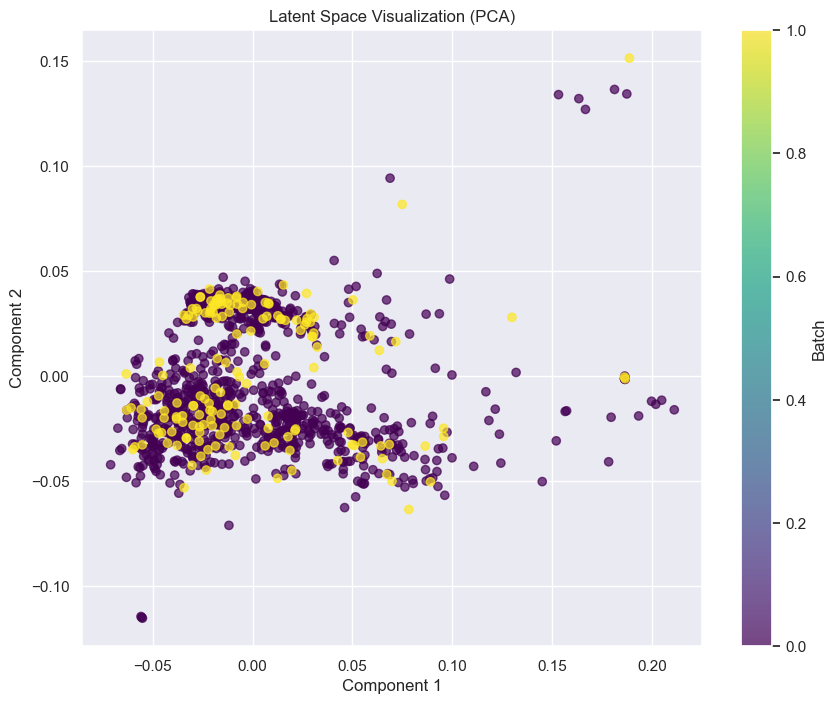

In [142]:
# Assuming `train_loader` is your DataLoader and `model` is your ProteinGraphVAE instance
plot_latent_space(model, train_loader, device, method='pca')

In [143]:
def sample_and_decode(model, num_samples=5, device='cpu'):
    """
    Sample random latent vectors and decode them to check for diversity in outputs.

    Args:
        model: Trained ProteinGraphVAE model.
        num_samples: Number of samples to generate.
        device: torch device.

    Returns:
        List of decoded node features.
    """
    model.eval()
    decoded_samples = []

    with torch.no_grad():
        for _ in range(num_samples):
            z = torch.randn(1, model.latent_channels, device=device)
            node_counts = torch.tensor([500], device=device)  # Adjust node count as needed
            edge_index = torch.zeros((2, 0), dtype=torch.long, device=device)  # Dummy edge_index
            node_features, edge_attr = model.decode(z, node_counts, edge_index)
            decoded_samples.append(node_features.cpu().numpy())

    return decoded_samples

# Example usage
decoded_samples = sample_and_decode(model, num_samples=5, device=device)
for i, sample in enumerate(decoded_samples):
    print(f"Sample {i+1}:")
    print(sample)

Sample 1:
[[[ 0.6599704   0.6834936   0.7057872  ... -1.1915921  -0.10843679
   -0.6972113 ]
  [ 0.6586508   0.68318856  0.70682037 ... -1.200025   -0.08975749
   -0.70122516]
  [ 0.6582818   0.6827517   0.70686656 ... -1.1872483  -0.0970874
   -0.6912594 ]
  ...
  [ 0.6597301   0.6831943   0.704636   ... -1.1851091  -0.09390112
   -0.7083463 ]
  [ 0.65951675  0.68342     0.7063469  ... -1.1929048  -0.0866381
   -0.6991539 ]
  [ 0.66025406  0.6836637   0.70616055 ... -1.17794    -0.10637433
   -0.6940693 ]]]
Sample 2:
[[[ 0.653092    0.6755344   0.7158736  ... -1.1501751   0.13800937
   -0.5064504 ]
  [ 0.6517317   0.6742067   0.715618   ... -1.1591628   0.14981914
   -0.53189987]
  [ 0.65223926  0.67432463  0.71465254 ... -1.1555828   0.13372868
   -0.53169006]
  ...
  [ 0.6524808   0.6740791   0.71432686 ... -1.1652837   0.1396458
   -0.53039396]
  [ 0.65187955  0.6740967   0.7154348  ... -1.1549175   0.13112211
   -0.53827417]
  [ 0.6517359   0.67546105  0.7166405  ... -1.1490129   

In [144]:
import torch
import torch.nn.functional as F


import torch

import torch

def generate_protein(model, n_nodes=500, device='cpu', feature_stats=None):
    """
    Generate a new protein structure from random latent vector

    Args:
        model: Trained ProteinGraphVAE model
        n_nodes: Number of nodes to generate
        device: torch device
        feature_stats: Tuple of (means, stds) used during training for normalization
    """
    model.eval()
    z = torch.randn(1, model.latent_channels, device=device)
    node_counts = torch.tensor([n_nodes], device=device)

    # Generate the edge index using a simple approach
    edge_probability = 0.1
    num_edges = int(n_nodes * (n_nodes - 1) * edge_probability / 2)
    row = torch.randint(0, n_nodes, (num_edges,), device=device)
    col = torch.randint(0, n_nodes, (num_edges,), device=device)
    edge_index = torch.stack([row, col], dim=0)

    with torch.no_grad():
        node_features, edge_attr = model.decode(z, node_counts, edge_index)

        # Denormalize if stats provided
        if feature_stats is not None:
            means, stds = feature_stats
            node_features = node_features * stds + means

    return node_features, edge_index, edge_attr

def plot_protein_structure(node_features, edge_index, title="Protein Structure"):
    coords = node_features[:, :3].cpu().numpy()
    edge_index_np = edge_index.cpu().numpy()

    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection='3d')

    # Plot nodes
    ax.scatter(coords[:, 0], coords[:, 1], coords[:, 2], s=50, c='blue')

    # Plot edges
    edges_x = []
    edges_y = []
    edges_z = []
    for i in range(edge_index_np.shape[1]):
        start_idx = edge_index_np[0, i]
        end_idx = edge_index_np[1, i]

        # Check if the indices are within the range of the node_features tensor
        if start_idx < coords.shape[0] and end_idx < coords.shape[0]:
            edges_x.extend([coords[start_idx, 0], coords[end_idx, 0], None])
            edges_y.extend([coords[start_idx, 1], coords[end_idx, 1], None])
            edges_z.extend([coords[start_idx, 2], coords[end_idx, 2], None])

    ax.plot(edges_x, edges_y, edges_z, c='gray', linewidth=1)

    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_title(title)
    plt.show()
    
def print_node_statistics(node_features):
    """
    Print statistics about the generated nodes
    """
    print("\nNode Feature Statistics:")
    print(f"Number of nodes: {node_features.shape[0]}")

    # Print statistics for each feature
    feature_names = ['Mass', 'Avg Neighbor Dist', 'Max Neighbor Dist',
                     'Neighbor Count', 'Small Molecules', 'X', 'Y', 'Z']

    for i, name in enumerate(feature_names):
        if i == 1:  # Distance features are 2D
            values = node_features[:, 1:3]
            mean = values.mean(dim=0)
            std = values.std(dim=0)
            print(f"\n{name}:")
            print(f"Mean: {mean.tolist()}")
            print(f"Std: {std.tolist()}")
        elif i < 5:  # Other scalar features
            values = node_features[:, i]
            print(f"\n{name}:")
            print(f"Mean: {values.mean():.3f}")
            print(f"Std: {values.std():.3f}")
            print(f"Min: {values.min():.3f}")
            print(f"Max: {values.max():.3f}")

    # Print coordinate statistics
    coords = node_features[:, 5:8]
    print("\nCoordinate Statistics:")
    print(f"Center of mass: {coords.mean(dim=0).tolist()}")
    print(f"Spatial extent: {coords.std(dim=0).tolist()}")

# Usage example:
def generate_and_visualize_protein(model, n_nodes=500, device='cpu'):
    """
    Generate and visualize a new protein structure
    """
    # Generate protein
    node_features, edge_index, edge_attr = generate_protein(model, n_nodes, device)

    # Print statistics
    print_node_statistics(node_features)

    # Plot structure
    plot_protein_structure(node_features, edge_index)

    return node_features, edge_index, edge_attr


Node Feature Statistics:
Number of nodes: 1

Mass:
Mean: 0.064
Std: 0.768
Min: -1.252
Max: 0.709

Avg Neighbor Dist:
Mean: [[0.6474595665931702, 0.6744288802146912, 0.7081311345100403, 0.6639198064804077, 0.10756012797355652, -1.2474534511566162, -0.19567275047302246, -0.8723143339157104], [0.6473450064659119, 0.6746131181716919, 0.7083887457847595, 0.6636079549789429, 0.10556092113256454, -1.2472491264343262, -0.17262117564678192, -0.8647013902664185]]
Std: [[nan, nan, nan, nan, nan, nan, nan, nan], [nan, nan, nan, nan, nan, nan, nan, nan]]

Max Neighbor Dist:
Mean: 0.064
Std: 0.768
Min: -1.247
Max: 0.708

Neighbor Count:
Mean: 0.060
Std: 0.769
Min: -1.241
Max: 0.707

Small Molecules:
Mean: 0.067
Std: 0.760
Min: -1.218
Max: 0.708

Coordinate Statistics:
Center of mass: [[0.6469613909721375, 0.6749606132507324, 0.7084682583808899, 0.6635770797729492, 0.10556888580322266, -1.244410753250122, -0.18467830121517181, -0.8767148852348328], [0.6481122970581055, 0.6747264266014099, 0.70833903

/var/folders/lp/38fnv8v91rqdkwbf17xlnxyh0000gn/T/ipykernel_91343/3658105207.py:87: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/ReduceOps.cpp:1760.)
  std = values.std(dim=0)
/var/folders/lp/38fnv8v91rqdkwbf17xlnxyh0000gn/T/ipykernel_91343/3658105207.py:103: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/ReduceOps.cpp:1760.)
  print(f"Spatial extent: {coords.std(dim=0).tolist()}")


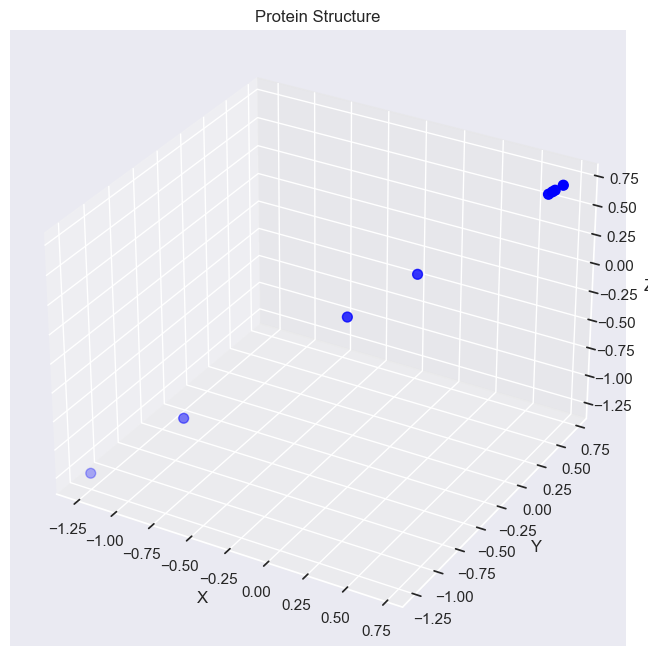


Node Feature Statistics:
Number of nodes: 1

Mass:
Mean: 0.064
Std: 0.768
Min: -1.252
Max: 0.709

Avg Neighbor Dist:
Mean: [[0.6474595665931702, 0.6744288802146912, 0.7081311345100403, 0.6639198064804077, 0.10756012797355652, -1.2474534511566162, -0.19567275047302246, -0.8723143339157104], [0.6473450064659119, 0.6746131181716919, 0.7083887457847595, 0.6636079549789429, 0.10556092113256454, -1.2472491264343262, -0.17262117564678192, -0.8647013902664185]]
Std: [[nan, nan, nan, nan, nan, nan, nan, nan], [nan, nan, nan, nan, nan, nan, nan, nan]]

Max Neighbor Dist:
Mean: 0.064
Std: 0.768
Min: -1.247
Max: 0.708

Neighbor Count:
Mean: 0.060
Std: 0.769
Min: -1.241
Max: 0.707

Small Molecules:
Mean: 0.067
Std: 0.760
Min: -1.218
Max: 0.708

Coordinate Statistics:
Center of mass: [[0.6469613909721375, 0.6749606132507324, 0.7084682583808899, 0.6635770797729492, 0.10556888580322266, -1.244410753250122, -0.18467830121517181, -0.8767148852348328], [0.6481122970581055, 0.6747264266014099, 0.70833903

In [145]:
# Assuming you have a trained model
model = model.to(device)

# Generate and visualize a protein
node_features, edge_index, edge_attr = generate_and_visualize_protein(
    model,
    n_nodes=500,  # Adjust this number as needed
    device=device
)
print_node_statistics(node_features)

In [146]:
print_node_statistics(node_features)


Node Feature Statistics:
Number of nodes: 1

Mass:
Mean: 0.064
Std: 0.768
Min: -1.252
Max: 0.709

Avg Neighbor Dist:
Mean: [[0.6474595665931702, 0.6744288802146912, 0.7081311345100403, 0.6639198064804077, 0.10756012797355652, -1.2474534511566162, -0.19567275047302246, -0.8723143339157104], [0.6473450064659119, 0.6746131181716919, 0.7083887457847595, 0.6636079549789429, 0.10556092113256454, -1.2472491264343262, -0.17262117564678192, -0.8647013902664185]]
Std: [[nan, nan, nan, nan, nan, nan, nan, nan], [nan, nan, nan, nan, nan, nan, nan, nan]]

Max Neighbor Dist:
Mean: 0.064
Std: 0.768
Min: -1.247
Max: 0.708

Neighbor Count:
Mean: 0.060
Std: 0.769
Min: -1.241
Max: 0.707

Small Molecules:
Mean: 0.067
Std: 0.760
Min: -1.218
Max: 0.708

Coordinate Statistics:
Center of mass: [[0.6469613909721375, 0.6749606132507324, 0.7084682583808899, 0.6635770797729492, 0.10556888580322266, -1.244410753250122, -0.18467830121517181, -0.8767148852348328], [0.6481122970581055, 0.6747264266014099, 0.70833903

/var/folders/lp/38fnv8v91rqdkwbf17xlnxyh0000gn/T/ipykernel_91343/3658105207.py:87: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/ReduceOps.cpp:1760.)
  std = values.std(dim=0)
/var/folders/lp/38fnv8v91rqdkwbf17xlnxyh0000gn/T/ipykernel_91343/3658105207.py:103: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/ReduceOps.cpp:1760.)
  print(f"Spatial extent: {coords.std(dim=0).tolist()}")


/opt/anaconda3/envs/untitled/lib/python3.8/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Dataset prepared:
Number of training graphs: 1308
Number of test graphs: 328
Number of features per node: 8
Feature means: tensor([-2.2879e-09, -4.5757e-10,  3.4494e-09, -1.2249e-08,  1.7266e-09,
         3.9840e-09,  6.5853e-09,  3.4648e-09])
Feature stds: tensor([1., 1., 1., 1., 1., 1., 1., 1.])
Starting training for 10 epochs...
Training on device: cpu
Number of training batches: 82
Number of validation batches: 21
KL annealing: 1e-05 -> 0.005 over 25 epochs
Orthogonal regularization strength: 0.1


Epoch 1/10 [Train]:   0%|          | 0/82 [00:00<?, ?it/s]


Batch shapes:
Input x shape: torch.Size([26788, 8])
Edge index shape: torch.Size([2, 107152])
Edge attr shape: torch.Size([107152, 1])
Reconstruction shape: torch.Size([16, 8803, 8])
Edge reconstruction shape: torch.Size([107152, 1])

Detailed loss diagnostics:
Raw recon_loss: 0.6965
Raw KL loss: 0.3528
Ortho loss: 1.4975
Current beta: 0.0000
mu mean: -0.0313, std: 0.1406
logvar mean: 0.9687, std: 0.1225
mass: 0.1449
distance: 0.1324
count: 0.0605
small_mol: 0.0659
coord: 0.1987
edge: 0.0941


Epoch 1/10 [Train]:  12%|█▏        | 10/82 [00:11<01:08,  1.05it/s, loss=2.0055, recon=0.5648, kl=0.3758, ortho=1.4407]


Detailed loss diagnostics:
Raw recon_loss: 0.5632
Raw KL loss: 0.3639
Ortho loss: 1.4436
Current beta: 0.0000
mu mean: -0.0025, std: 0.0972
logvar mean: 0.9895, std: 0.1153
mass: 0.1565
distance: 0.1296
count: 0.0582
small_mol: 0.0629
coord: 0.0705
edge: 0.0856


Epoch 1/10 [Train]:  24%|██▍       | 20/82 [00:20<00:53,  1.15it/s, loss=1.9913, recon=0.5525, kl=0.3606, ortho=1.4388]


Detailed loss diagnostics:
Raw recon_loss: 0.6508
Raw KL loss: 0.3498
Ortho loss: 1.4450
Current beta: 0.0000
mu mean: 0.0052, std: 0.1272
logvar mean: 0.9649, std: 0.1346
mass: 0.1656
distance: 0.2056
count: 0.0871
small_mol: 0.0568
coord: 0.0555
edge: 0.0803


Epoch 1/10 [Train]:  37%|███▋      | 30/82 [00:29<00:49,  1.04it/s, loss=1.8911, recon=0.4543, kl=0.3707, ortho=1.4368]


Detailed loss diagnostics:
Raw recon_loss: 0.4625
Raw KL loss: 0.3838
Ortho loss: 1.4276
Current beta: 0.0000
mu mean: -0.0328, std: 0.1462
logvar mean: 0.9911, std: 0.1787
mass: 0.1260
distance: 0.1077
count: 0.0509
small_mol: 0.0519
coord: 0.0532
edge: 0.0728


Epoch 1/10 [Train]:  49%|████▉     | 40/82 [00:41<00:54,  1.30s/it, loss=1.8975, recon=0.4695, kl=0.3770, ortho=1.4280]


Detailed loss diagnostics:
Raw recon_loss: 0.3956
Raw KL loss: 0.3919
Ortho loss: 1.4360
Current beta: 0.0000
mu mean: -0.0294, std: 0.1625
logvar mean: 0.9915, std: 0.2012
mass: 0.1055
distance: 0.0921
count: 0.0466
small_mol: 0.0485
coord: 0.0334
edge: 0.0695


Epoch 1/10 [Train]:  61%|██████    | 50/82 [00:52<00:34,  1.06s/it, loss=1.8769, recon=0.4482, kl=0.3805, ortho=1.4287]


Detailed loss diagnostics:
Raw recon_loss: 0.4520
Raw KL loss: 0.3932
Ortho loss: 1.4257
Current beta: 0.0000
mu mean: -0.0274, std: 0.1654
logvar mean: 0.9957, std: 0.1877
mass: 0.1143
distance: 0.1174
count: 0.0590
small_mol: 0.0395
coord: 0.0522
edge: 0.0697


Epoch 1/10 [Train]:  73%|███████▎  | 60/82 [01:04<00:25,  1.16s/it, loss=1.7849, recon=0.3645, kl=0.3767, ortho=1.4204]


Detailed loss diagnostics:
Raw recon_loss: 0.3534
Raw KL loss: 0.3540
Ortho loss: 1.4231
Current beta: 0.0000
mu mean: -0.0049, std: 0.1033
logvar mean: 0.9693, std: 0.1529
mass: 0.0984
distance: 0.0843
count: 0.0391
small_mol: 0.0347
coord: 0.0299
edge: 0.0671


Epoch 1/10 [Train]:  85%|████████▌ | 70/82 [01:16<00:16,  1.37s/it, loss=2.1214, recon=0.6965, kl=0.4232, ortho=1.4250]


Detailed loss diagnostics:
Raw recon_loss: 0.3442
Raw KL loss: 0.3859
Ortho loss: 1.4202
Current beta: 0.0000
mu mean: -0.0465, std: 0.1607
logvar mean: 0.9675, std: 0.2569
mass: 0.0932
distance: 0.0808
count: 0.0358
small_mol: 0.0371
coord: 0.0309
edge: 0.0665


Epoch 1/10 [Train]:  98%|█████████▊| 80/82 [01:27<00:02,  1.18s/it, loss=1.7798, recon=0.3598, kl=0.3687, ortho=1.4199]


Detailed loss diagnostics:
Raw recon_loss: 0.3568
Raw KL loss: 0.3847
Ortho loss: 1.4195
Current beta: 0.0000
mu mean: -0.0175, std: 0.1290
logvar mean: 0.9806, std: 0.2259
mass: 0.0891
distance: 0.0880
count: 0.0329
small_mol: 0.0324
coord: 0.0459
edge: 0.0685


Epoch 1/10 [Train]: 100%|██████████| 82/82 [01:29<00:00,  1.09s/it, loss=1.7567, recon=0.3247, kl=0.3791, ortho=1.4320]



Starting validation...


Epoch 1/10 [Valid]: 100%|██████████| 21/21 [00:07<00:00,  2.80it/s]



Epoch [1/10] - Time: 96.67s
Train - Total: 1.9094, Recon: 0.4756, KL: 0.3798, Ortho: 1.4338, Beta: 0.0000
Feature Losses:
  mass_loss: 0.1223
  distance_loss: 0.1110
  count_loss: 0.0638
  small_mol_loss: 0.0483
  coord_loss: 0.0559
  edge_loss: 0.0743


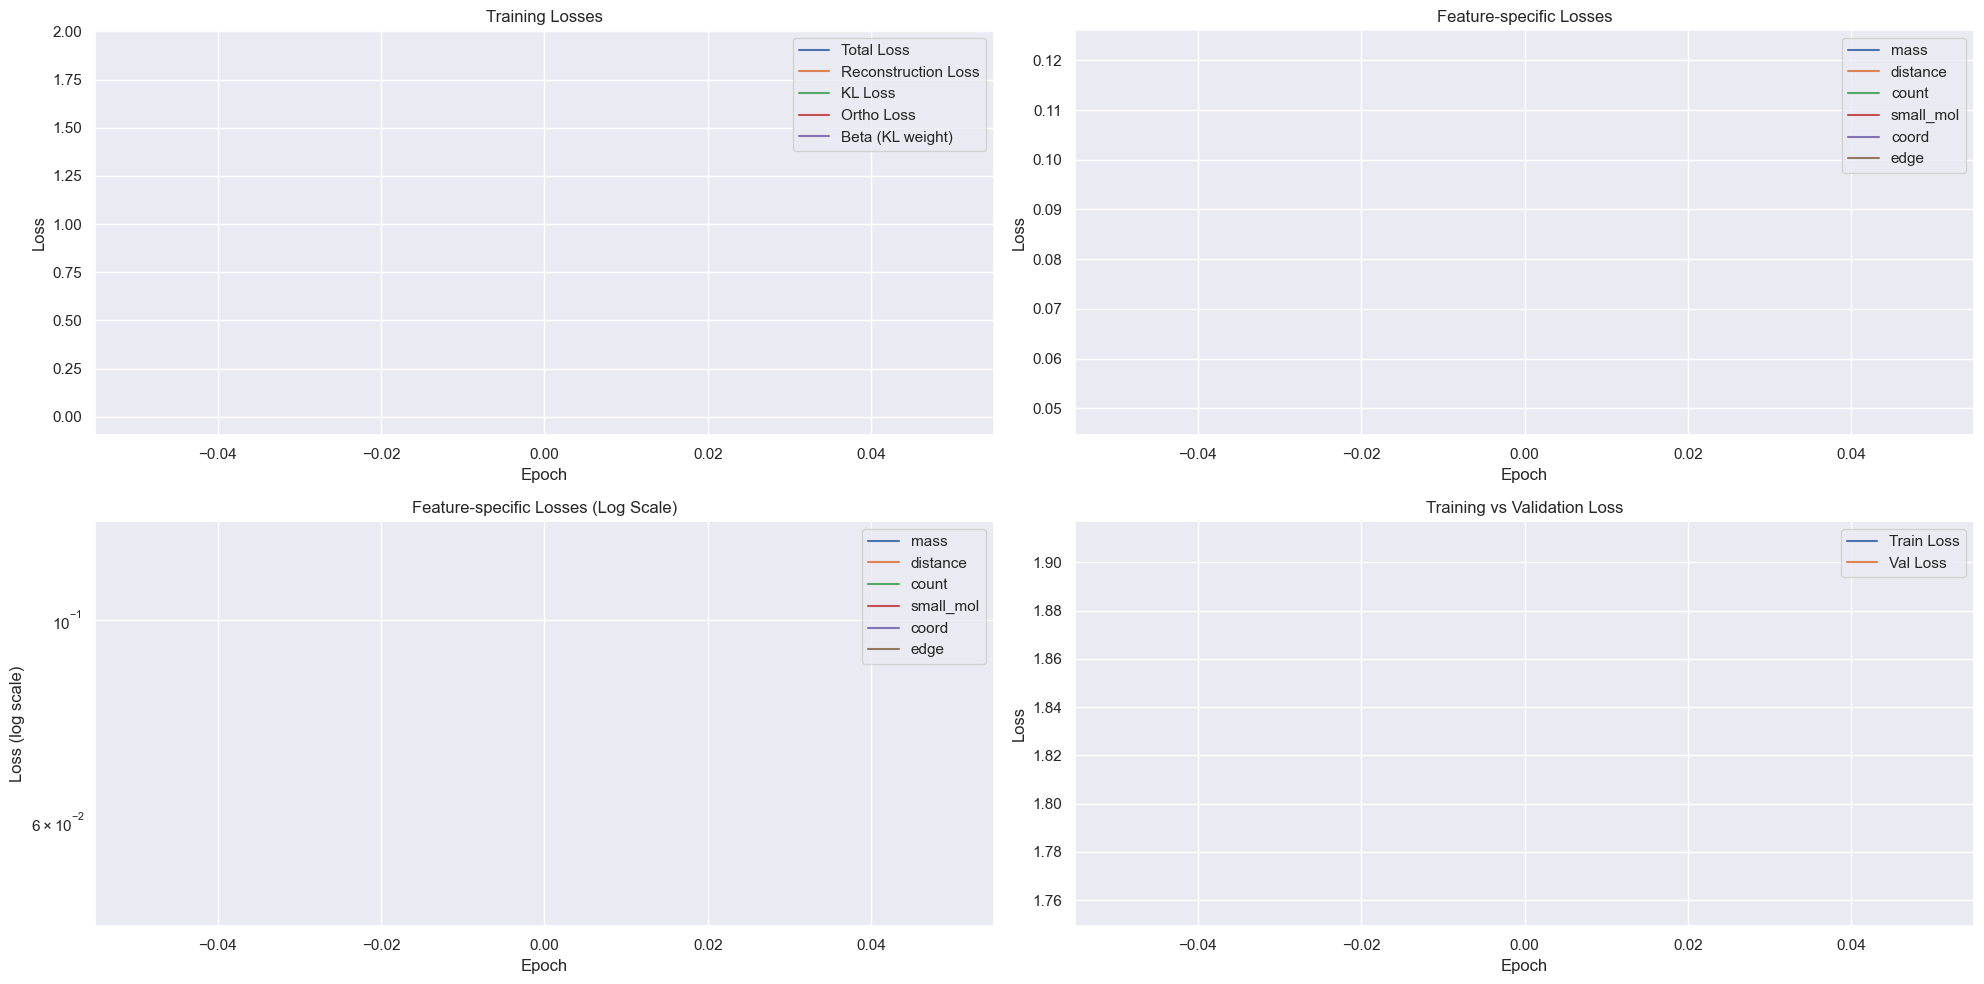

Epoch 2/10 [Train]:   0%|          | 0/82 [00:00<?, ?it/s]


Detailed loss diagnostics:
Raw recon_loss: 0.3108
Raw KL loss: 0.3815
Ortho loss: 1.4198
Current beta: 0.0002
mu mean: -0.0429, std: 0.1357
logvar mean: 0.9664, std: 0.2520
mass: 0.0764
distance: 0.0712
count: 0.0313
small_mol: 0.0276
coord: 0.0358
edge: 0.0687


Epoch 2/10 [Train]:  12%|█▏        | 10/82 [00:12<01:28,  1.24s/it, loss=1.7409, recon=0.3132, kl=0.3809, ortho=1.4277]


Detailed loss diagnostics:
Raw recon_loss: 0.2739
Raw KL loss: 0.3816
Ortho loss: 1.4212
Current beta: 0.0002
mu mean: -0.0295, std: 0.1289
logvar mean: 0.9790, std: 0.2172
mass: 0.0701
distance: 0.0659
count: 0.0298
small_mol: 0.0146
coord: 0.0266
edge: 0.0671


Epoch 2/10 [Train]:  24%|██▍       | 20/82 [00:22<01:01,  1.01it/s, loss=1.7757, recon=0.3553, kl=0.3823, ortho=1.4204]


Detailed loss diagnostics:
Raw recon_loss: 0.2875
Raw KL loss: 0.3865
Ortho loss: 1.4290
Current beta: 0.0002
mu mean: -0.0139, std: 0.1124
logvar mean: 0.9857, std: 0.2212
mass: 0.0804
distance: 0.0668
count: 0.0284
small_mol: 0.0179
coord: 0.0254
edge: 0.0687


Epoch 2/10 [Train]:  37%|███▋      | 30/82 [00:36<01:18,  1.51s/it, loss=1.7164, recon=0.2913, kl=0.3983, ortho=1.4251]


Detailed loss diagnostics:
Raw recon_loss: 0.3371
Raw KL loss: 0.3864
Ortho loss: 1.4251
Current beta: 0.0002
mu mean: -0.0274, std: 0.1430
logvar mean: 0.9740, std: 0.2392
mass: 0.0879
distance: 0.0896
count: 0.0287
small_mol: 0.0192
coord: 0.0433
edge: 0.0686


Epoch 2/10 [Train]:  49%|████▉     | 40/82 [00:47<00:46,  1.11s/it, loss=1.7532, recon=0.3276, kl=0.4087, ortho=1.4256]


Detailed loss diagnostics:
Raw recon_loss: 0.3652
Raw KL loss: 0.3926
Ortho loss: 1.4199
Current beta: 0.0002
mu mean: -0.0311, std: 0.1407
logvar mean: 0.9746, std: 0.2556
mass: 0.1023
distance: 0.0959
count: 0.0299
small_mol: 0.0324
coord: 0.0374
edge: 0.0673


Epoch 2/10 [Train]:  61%|██████    | 50/82 [00:57<00:32,  1.03s/it, loss=1.7665, recon=0.3462, kl=0.4062, ortho=1.4202]


Detailed loss diagnostics:
Raw recon_loss: 0.2878
Raw KL loss: 0.4053
Ortho loss: 1.4235
Current beta: 0.0002
mu mean: -0.0258, std: 0.1591
logvar mean: 0.9761, std: 0.2801
mass: 0.0733
distance: 0.0673
count: 0.0268
small_mol: 0.0219
coord: 0.0307
edge: 0.0678


Epoch 2/10 [Train]:  73%|███████▎  | 60/82 [01:07<00:22,  1.01s/it, loss=1.7488, recon=0.3282, kl=0.3965, ortho=1.4205]


Detailed loss diagnostics:
Raw recon_loss: 0.3105
Raw KL loss: 0.4020
Ortho loss: 1.4179
Current beta: 0.0002
mu mean: -0.0342, std: 0.1553
logvar mean: 0.9716, std: 0.2830
mass: 0.0849
distance: 0.0794
count: 0.0276
small_mol: 0.0280
coord: 0.0250
edge: 0.0657


Epoch 2/10 [Train]:  85%|████████▌ | 70/82 [01:15<00:09,  1.31it/s, loss=1.8257, recon=0.3992, kl=0.4485, ortho=1.4264]


Detailed loss diagnostics:
Raw recon_loss: 0.3563
Raw KL loss: 0.5682
Ortho loss: 1.4193
Current beta: 0.0002
mu mean: -0.0437, std: 0.4110
logvar mean: 0.9721, std: 0.4480
mass: 0.0902
distance: 0.0911
count: 0.0283
small_mol: 0.0532
coord: 0.0266
edge: 0.0670


Epoch 2/10 [Train]:  98%|█████████▊| 80/82 [01:26<00:02,  1.05s/it, loss=1.7270, recon=0.3069, kl=0.3835, ortho=1.4200]


Detailed loss diagnostics:
Raw recon_loss: 0.2930
Raw KL loss: 0.4374
Ortho loss: 1.4190
Current beta: 0.0002
mu mean: -0.0349, std: 0.2151
logvar mean: 0.9667, std: 0.3492
mass: 0.0741
distance: 0.0714
count: 0.0267
small_mol: 0.0229
coord: 0.0309
edge: 0.0670


Epoch 2/10 [Train]: 100%|██████████| 82/82 [01:28<00:00,  1.07s/it, loss=1.7302, recon=0.3065, kl=0.4007, ortho=1.4236]



Starting validation...


Epoch 2/10 [Valid]: 100%|██████████| 21/21 [00:07<00:00,  2.99it/s]



Epoch [2/10] - Time: 95.12s
Train - Total: 1.7678, Recon: 0.3459, KL: 0.4129, Ortho: 1.4218, Beta: 0.0002
Feature Losses:
  mass_loss: 0.0844
  distance_loss: 0.0826
  count_loss: 0.0429
  small_mol_loss: 0.0302
  coord_loss: 0.0379
  edge_loss: 0.0679


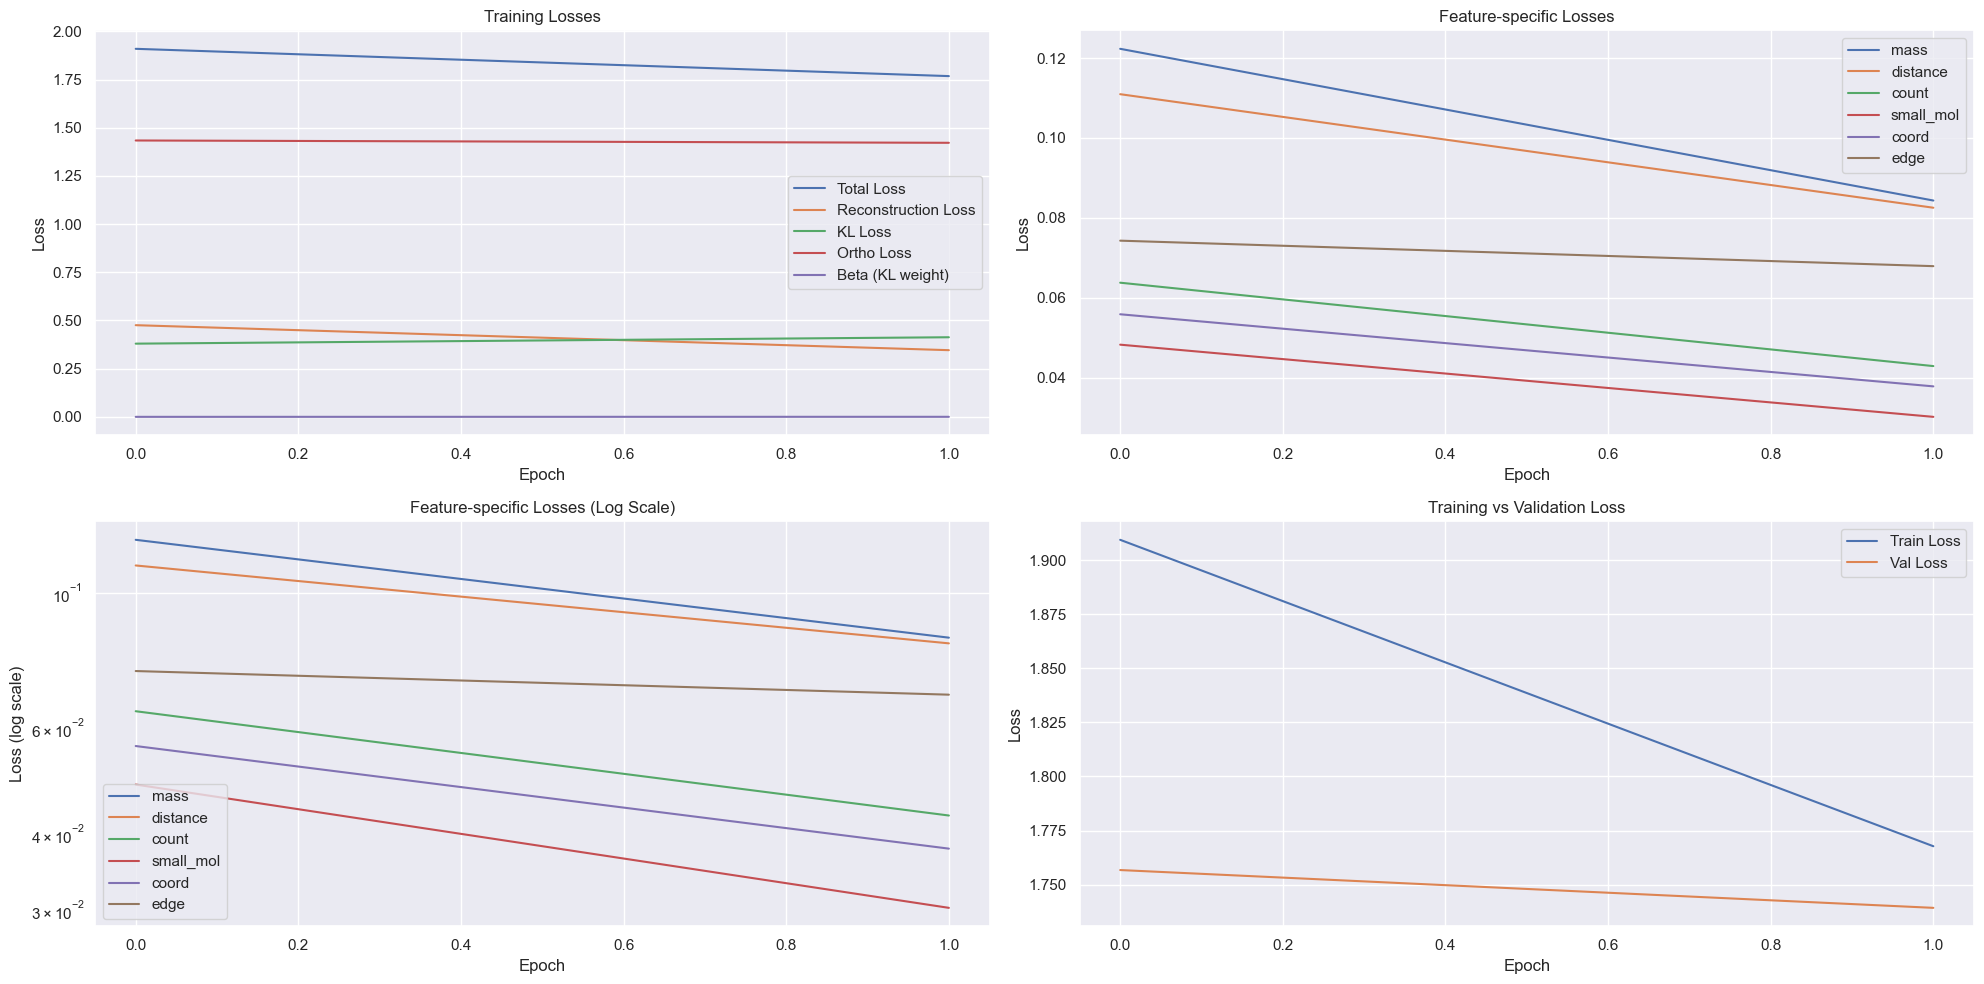

Epoch 3/10 [Train]:   0%|          | 0/82 [00:00<?, ?it/s]


Detailed loss diagnostics:
Raw recon_loss: 0.2902
Raw KL loss: 0.4174
Ortho loss: 1.4218
Current beta: 0.0004
mu mean: -0.0204, std: 0.1840
logvar mean: 0.9813, std: 0.2897
mass: 0.0694
distance: 0.0678
count: 0.0262
small_mol: 0.0128
coord: 0.0460
edge: 0.0679


Epoch 3/10 [Train]:  12%|█▏        | 10/82 [00:12<01:21,  1.13s/it, loss=1.7485, recon=0.3303, kl=0.3861, ortho=1.4180]


Detailed loss diagnostics:
Raw recon_loss: 0.3417
Raw KL loss: 0.3886
Ortho loss: 1.4183
Current beta: 0.0004
mu mean: 0.0093, std: 0.1338
logvar mean: 0.9748, std: 0.2451
mass: 0.0811
distance: 0.0791
count: 0.0271
small_mol: 0.0214
coord: 0.0666
edge: 0.0663


Epoch 3/10 [Train]:  24%|██▍       | 20/82 [00:23<00:59,  1.03it/s, loss=1.7424, recon=0.3253, kl=0.4839, ortho=1.4169]


Detailed loss diagnostics:
Raw recon_loss: 0.5588
Raw KL loss: 0.4920
Ortho loss: 1.4200
Current beta: 0.0004
mu mean: -0.0016, std: 0.2984
logvar mean: 0.9876, std: 0.3571
mass: 0.0825
distance: 0.1139
count: 0.2215
small_mol: 0.0188
coord: 0.0475
edge: 0.0746


Epoch 3/10 [Train]:  37%|███▋      | 30/82 [00:33<00:49,  1.05it/s, loss=1.7457, recon=0.3247, kl=0.3872, ortho=1.4208]


Detailed loss diagnostics:
Raw recon_loss: 0.3382
Raw KL loss: 0.5001
Ortho loss: 1.4180
Current beta: 0.0004
mu mean: -0.0406, std: 0.3281
logvar mean: 0.9504, std: 0.4321
mass: 0.0830
distance: 0.0791
count: 0.0272
small_mol: 0.0447
coord: 0.0383
edge: 0.0660


Epoch 3/10 [Train]:  49%|████▉     | 40/82 [00:46<00:52,  1.26s/it, loss=1.7625, recon=0.3424, kl=0.4365, ortho=1.4199]


Detailed loss diagnostics:
Raw recon_loss: 0.3027
Raw KL loss: 0.4510
Ortho loss: 1.4178
Current beta: 0.0004
mu mean: -0.0319, std: 0.2075
logvar mean: 0.9733, std: 0.3678
mass: 0.0799
distance: 0.0768
count: 0.0268
small_mol: 0.0288
coord: 0.0218
edge: 0.0687


Epoch 3/10 [Train]:  61%|██████    | 50/82 [00:54<00:24,  1.31it/s, loss=1.8015, recon=0.3857, kl=0.3845, ortho=1.4156]


Detailed loss diagnostics:
Raw recon_loss: 0.3040
Raw KL loss: 0.5290
Ortho loss: 1.4177
Current beta: 0.0004
mu mean: -0.0846, std: 0.2931
logvar mean: 0.9473, std: 0.4985
mass: 0.0760
distance: 0.0717
count: 0.0264
small_mol: 0.0248
coord: 0.0365
edge: 0.0686


Epoch 3/10 [Train]:  73%|███████▎  | 60/82 [01:03<00:19,  1.10it/s, loss=1.9765, recon=0.5591, kl=0.6945, ortho=1.4171]


Detailed loss diagnostics:
Raw recon_loss: 0.2919
Raw KL loss: 0.7403
Ortho loss: 1.4183
Current beta: 0.0004
mu mean: 0.0434, std: 0.4907
logvar mean: 0.9701, std: 0.5323
mass: 0.0737
distance: 0.0699
count: 0.0262
small_mol: 0.0209
coord: 0.0336
edge: 0.0677


Epoch 3/10 [Train]:  85%|████████▌ | 70/82 [01:13<00:12,  1.01s/it, loss=1.6989, recon=0.2831, kl=0.4717, ortho=1.4156]


Detailed loss diagnostics:
Raw recon_loss: 0.3073
Raw KL loss: 0.4040
Ortho loss: 1.4158
Current beta: 0.0004
mu mean: -0.0293, std: 0.1556
logvar mean: 0.9694, std: 0.2903
mass: 0.0817
distance: 0.0760
count: 0.0270
small_mol: 0.0322
coord: 0.0213
edge: 0.0691


Epoch 3/10 [Train]:  98%|█████████▊| 80/82 [01:25<00:02,  1.50s/it, loss=1.6814, recon=0.2637, kl=1.3213, ortho=1.4172]


Detailed loss diagnostics:
Raw recon_loss: 0.3420
Raw KL loss: 0.5612
Ortho loss: 1.4182
Current beta: 0.0004
mu mean: -0.1159, std: 0.3460
logvar mean: 0.9354, std: 0.5229
mass: 0.0866
distance: 0.0842
count: 0.0269
small_mol: 0.0486
coord: 0.0280
edge: 0.0677


Epoch 3/10 [Train]: 100%|██████████| 82/82 [01:27<00:00,  1.06s/it, loss=1.7404, recon=0.3214, kl=0.5234, ortho=1.4188]



Starting validation...


Epoch 3/10 [Valid]: 100%|██████████| 21/21 [00:07<00:00,  2.96it/s]



Epoch [3/10] - Time: 94.23s
Train - Total: 1.7645, Recon: 0.3456, KL: 0.4887, Ortho: 1.4187, Beta: 0.0004
Feature Losses:
  mass_loss: 0.0831
  distance_loss: 0.0832
  count_loss: 0.0450
  small_mol_loss: 0.0298
  coord_loss: 0.0366
  edge_loss: 0.0678


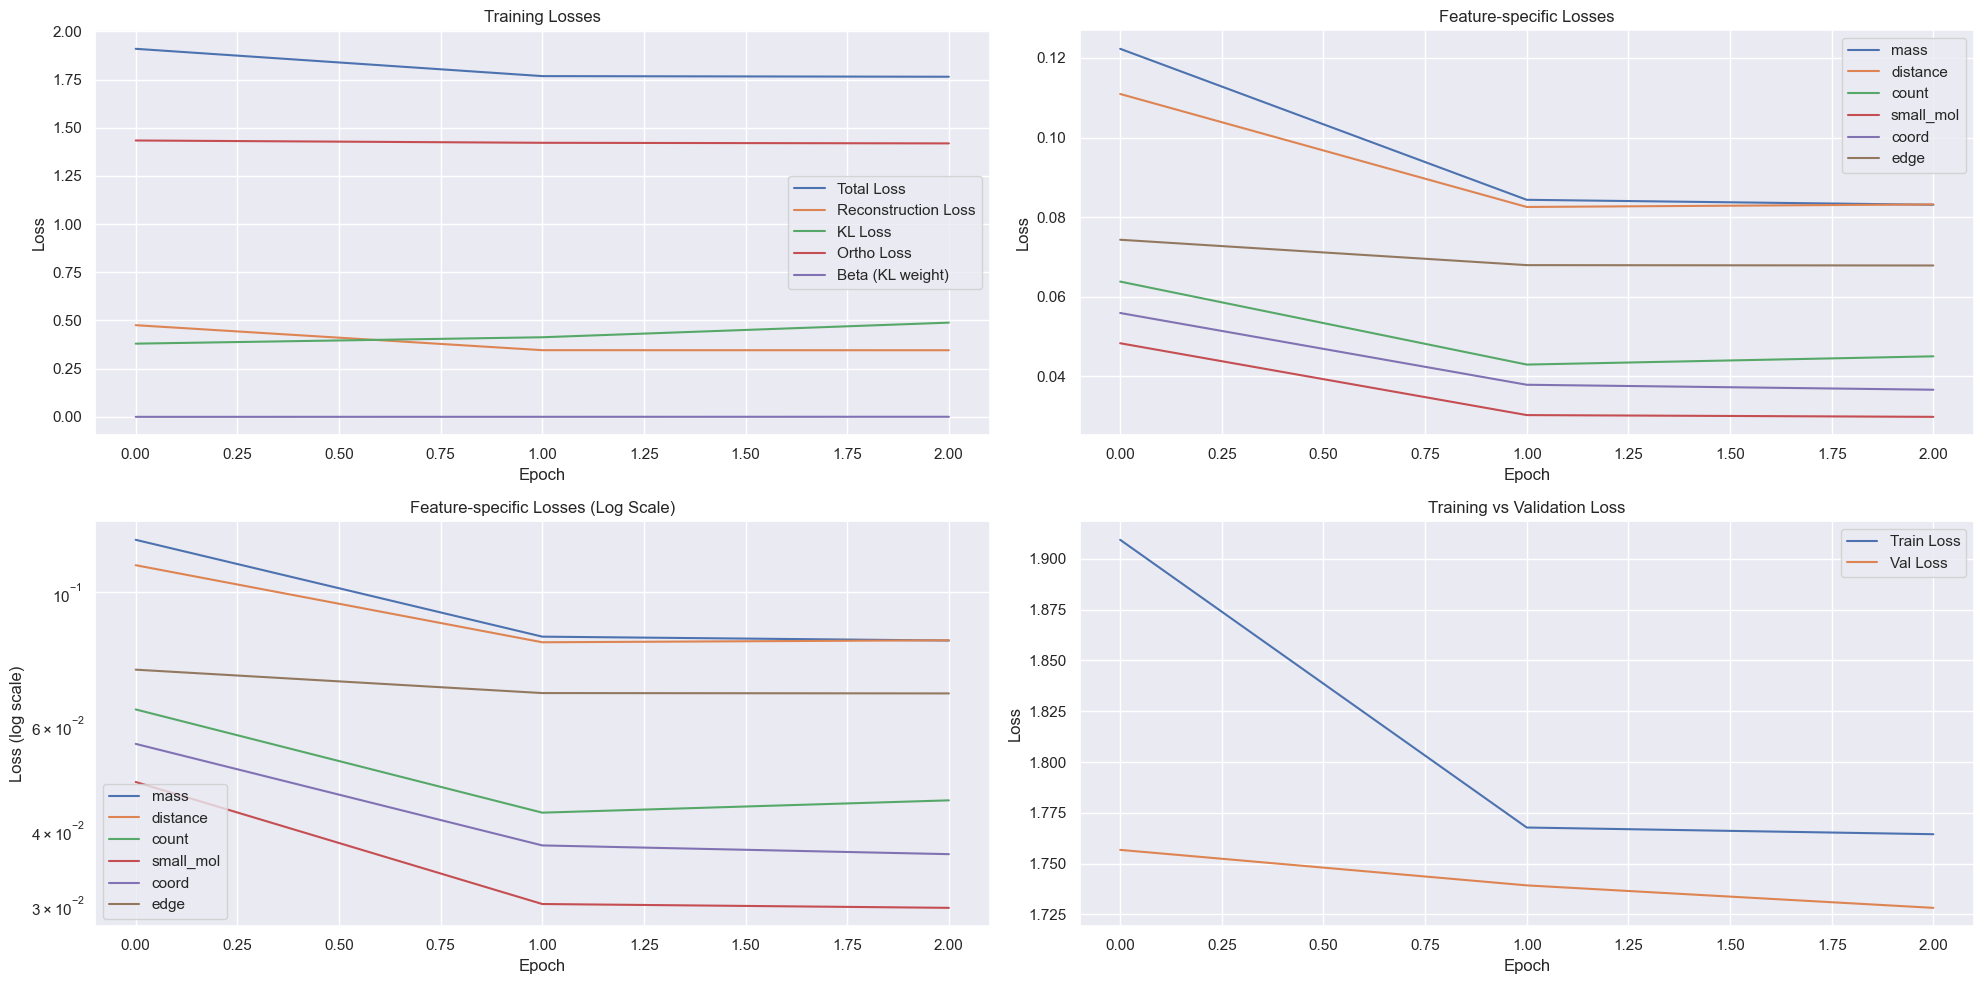

Epoch 4/10 [Train]:   0%|          | 0/82 [00:00<?, ?it/s]


Detailed loss diagnostics:
Raw recon_loss: 0.3677
Raw KL loss: 16.1298
Ortho loss: 1.4219
Current beta: 0.0006
mu mean: 0.0557, std: 1.1372
logvar mean: 0.9310, std: 1.0968
mass: 0.0845
distance: 0.0873
count: 0.0271
small_mol: 0.0222
coord: 0.0799
edge: 0.0666


Epoch 4/10 [Train]:  12%|█▏        | 10/82 [00:10<01:15,  1.05s/it, loss=1.7098, recon=0.2923, kl=0.4658, ortho=1.4172]


Detailed loss diagnostics:
Raw recon_loss: 0.3155
Raw KL loss: 0.3871
Ortho loss: 1.4216
Current beta: 0.0006
mu mean: -0.0314, std: 0.1726
logvar mean: 0.9454, std: 0.2970
mass: 0.0898
distance: 0.0877
count: 0.0273
small_mol: 0.0141
coord: 0.0300
edge: 0.0665


Epoch 4/10 [Train]:  24%|██▍       | 20/82 [00:23<01:22,  1.33s/it, loss=1.7307, recon=0.3129, kl=0.5746, ortho=1.4175]


Detailed loss diagnostics:
Raw recon_loss: 0.2942
Raw KL loss: 0.4054
Ortho loss: 1.4157
Current beta: 0.0006
mu mean: -0.0319, std: 0.2407
logvar mean: 0.9234, std: 0.3473
mass: 0.0790
distance: 0.0762
count: 0.0269
small_mol: 0.0186
coord: 0.0275
edge: 0.0661


Epoch 4/10 [Train]:  37%|███▋      | 30/82 [00:33<00:57,  1.10s/it, loss=1.7240, recon=0.3083, kl=0.5235, ortho=1.4153]


Detailed loss diagnostics:
Raw recon_loss: 0.2883
Raw KL loss: 0.3787
Ortho loss: 1.4143
Current beta: 0.0006
mu mean: 0.0053, std: 0.2116
logvar mean: 0.9341, std: 0.2776
mass: 0.0788
distance: 0.0768
count: 0.0264
small_mol: 0.0122
coord: 0.0268
edge: 0.0673


Epoch 4/10 [Train]:  49%|████▉     | 40/82 [00:45<00:46,  1.11s/it, loss=1.6709, recon=0.2496, kl=0.3852, ortho=1.4211]


Detailed loss diagnostics:
Raw recon_loss: 0.2845
Raw KL loss: 0.4223
Ortho loss: 1.4187
Current beta: 0.0006
mu mean: -0.0528, std: 0.2686
logvar mean: 0.9235, std: 0.3663
mass: 0.0725
distance: 0.0702
count: 0.0262
small_mol: 0.0237
coord: 0.0255
edge: 0.0664


Epoch 4/10 [Train]:  61%|██████    | 50/82 [00:56<00:35,  1.12s/it, loss=1.7058, recon=0.2851, kl=0.9139, ortho=1.4202]


Detailed loss diagnostics:
Raw recon_loss: 0.2812
Raw KL loss: 0.6025
Ortho loss: 1.4181
Current beta: 0.0006
mu mean: -0.0488, std: 0.5372
logvar mean: 0.8675, std: 0.5852
mass: 0.0716
distance: 0.0742
count: 0.0258
small_mol: 0.0171
coord: 0.0241
edge: 0.0684


Epoch 4/10 [Train]:  73%|███████▎  | 60/82 [01:05<00:18,  1.17it/s, loss=1.7464, recon=0.3299, kl=0.5195, ortho=1.4162]


Detailed loss diagnostics:
Raw recon_loss: 0.3967
Raw KL loss: 0.5345
Ortho loss: 1.4168
Current beta: 0.0006
mu mean: -0.0965, std: 0.4778
logvar mean: 0.8701, std: 0.5430
mass: 0.0959
distance: 0.0916
count: 0.0279
small_mol: 0.0763
coord: 0.0373
edge: 0.0676


Epoch 4/10 [Train]:  85%|████████▌ | 70/82 [01:15<00:12,  1.08s/it, loss=1.7253, recon=0.3078, kl=0.9214, ortho=1.4170]


Detailed loss diagnostics:
Raw recon_loss: 0.3694
Raw KL loss: 0.4990
Ortho loss: 1.4174
Current beta: 0.0006
mu mean: -0.0280, std: 0.4738
logvar mean: 0.8683, std: 0.4732
mass: 0.1024
distance: 0.0965
count: 0.0281
small_mol: 0.0355
coord: 0.0401
edge: 0.0668


Epoch 4/10 [Train]:  98%|█████████▊| 80/82 [01:25<00:01,  1.03it/s, loss=1.7284, recon=0.3098, kl=0.8210, ortho=1.4180]


Detailed loss diagnostics:
Raw recon_loss: 0.5494
Raw KL loss: 0.7462
Ortho loss: 1.4161
Current beta: 0.0006
mu mean: -0.0718, std: 0.8316
logvar mean: 0.6823, std: 0.8376
mass: 0.0841
distance: 0.1215
count: 0.2298
small_mol: 0.0219
coord: 0.0192
edge: 0.0729


Epoch 4/10 [Train]: 100%|██████████| 82/82 [01:27<00:00,  1.07s/it, loss=2.1805, recon=0.7608, kl=0.3889, ortho=1.4195]



Starting validation...


Epoch 4/10 [Valid]: 100%|██████████| 21/21 [00:07<00:00,  2.95it/s]



Epoch [4/10] - Time: 94.79s
Train - Total: 1.7556, Recon: 0.3374, KL: 0.8624, Ortho: 1.4177, Beta: 0.0006
Feature Losses:
  mass_loss: 0.0820
  distance_loss: 0.0827
  count_loss: 0.0471
  small_mol_loss: 0.0276
  coord_loss: 0.0301
  edge_loss: 0.0678


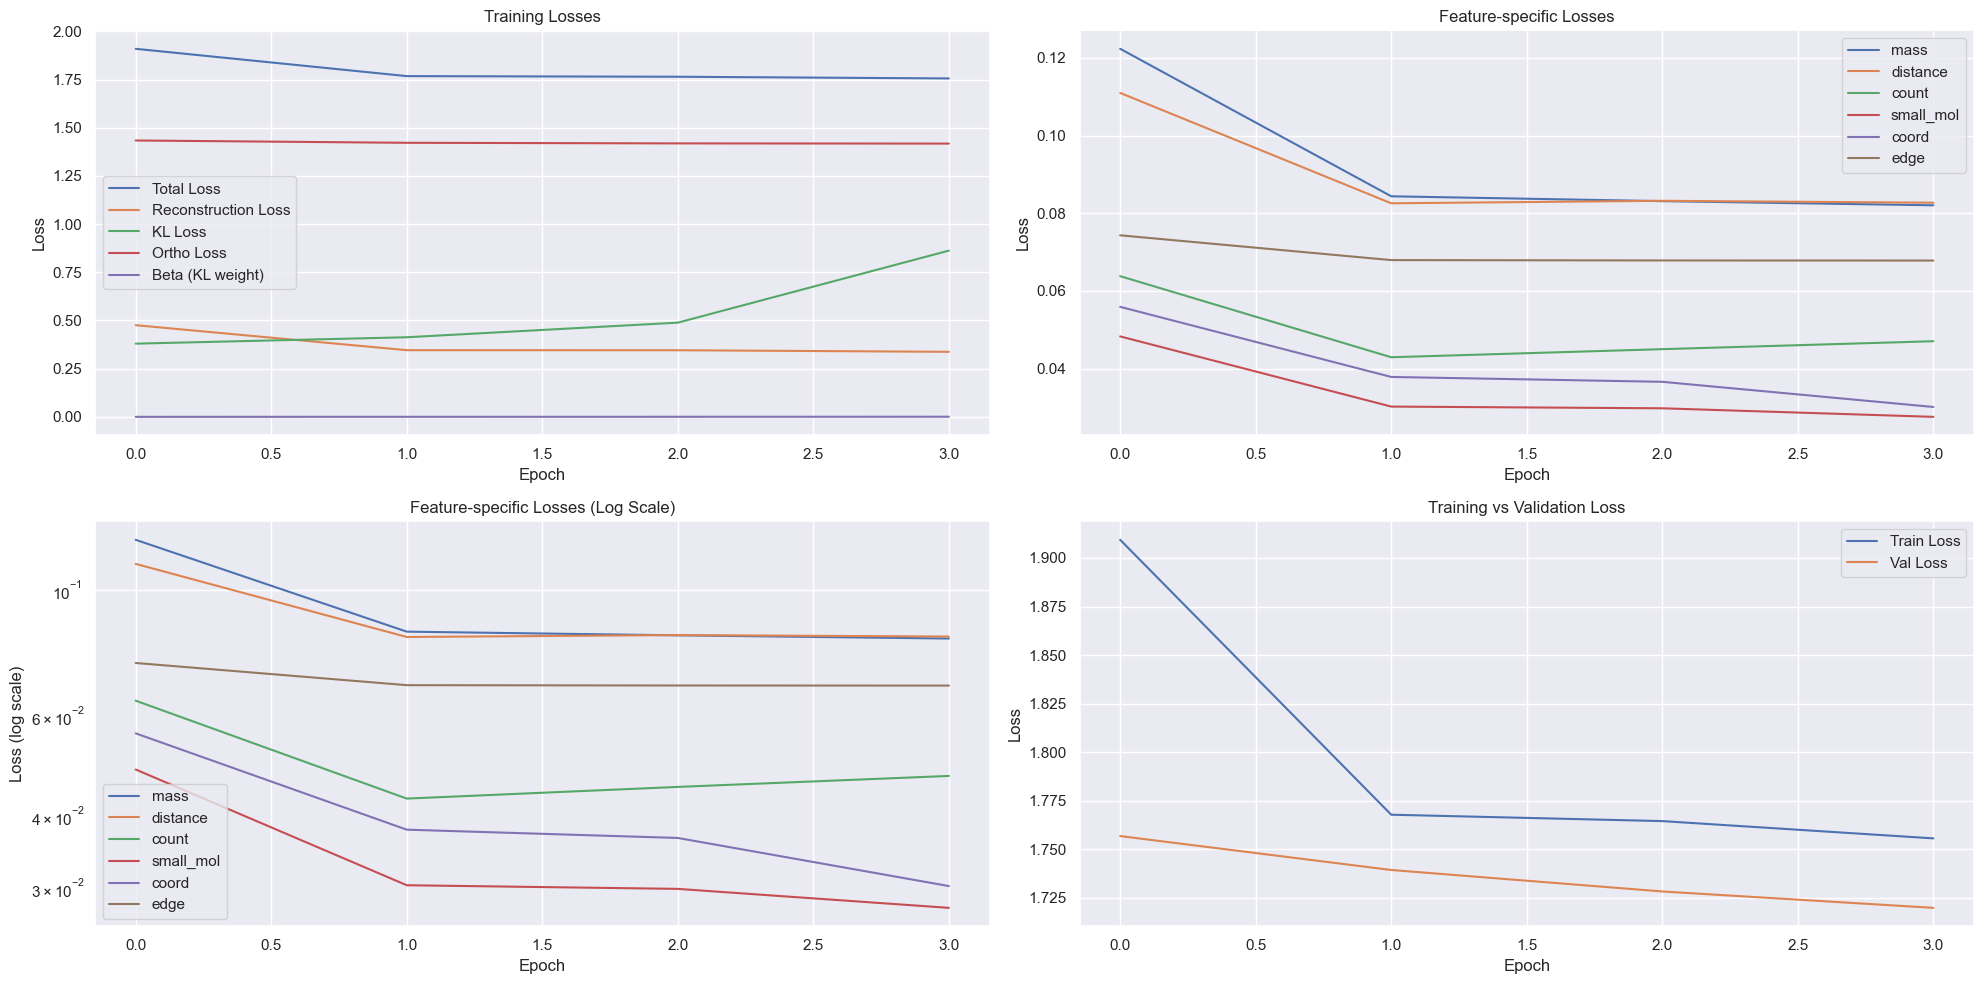

Epoch 5/10 [Train]:   0%|          | 0/82 [00:00<?, ?it/s]


Detailed loss diagnostics:
Raw recon_loss: 0.2807
Raw KL loss: 0.8535
Ortho loss: 1.4149
Current beta: 0.0008
mu mean: -0.0615, std: 0.9597
logvar mean: 0.6488, std: 0.8746
mass: 0.0746
distance: 0.0727
count: 0.0264
small_mol: 0.0222
coord: 0.0180
edge: 0.0668


Epoch 5/10 [Train]:  12%|█▏        | 10/82 [00:10<01:17,  1.08s/it, loss=1.7169, recon=0.2950, kl=0.7073, ortho=1.4213]


Detailed loss diagnostics:
Raw recon_loss: 0.7332
Raw KL loss: 0.5622
Ortho loss: 1.4175
Current beta: 0.0008
mu mean: -0.0893, std: 0.6293
logvar mean: 0.7557, std: 0.7120
mass: 0.0905
distance: 0.1755
count: 0.3511
small_mol: 0.0167
coord: 0.0242
edge: 0.0752


Epoch 5/10 [Train]:  24%|██▍       | 20/82 [00:19<01:11,  1.15s/it, loss=1.6961, recon=0.2754, kl=2.0892, ortho=1.4190]


Detailed loss diagnostics:
Raw recon_loss: 0.2555
Raw KL loss: 0.7577
Ortho loss: 1.4165
Current beta: 0.0008
mu mean: -0.0657, std: 0.9588
logvar mean: 0.5670, std: 0.8371
mass: 0.0670
distance: 0.0630
count: 0.0255
small_mol: 0.0161
coord: 0.0153
edge: 0.0685


Epoch 5/10 [Train]:  37%|███▋      | 30/82 [00:30<00:54,  1.06s/it, loss=1.7102, recon=0.2912, kl=1.4178, ortho=1.4179]


Detailed loss diagnostics:
Raw recon_loss: 0.2705
Raw KL loss: 0.7987
Ortho loss: 1.4198
Current beta: 0.0008
mu mean: 0.0200, std: 1.0228
logvar mean: 0.5141, std: 0.8410
mass: 0.0745
distance: 0.0726
count: 0.0263
small_mol: 0.0170
coord: 0.0135
edge: 0.0667


Epoch 5/10 [Train]:  49%|████▉     | 40/82 [00:41<00:50,  1.21s/it, loss=1.7534, recon=0.3373, kl=1.5008, ortho=1.4149]


Detailed loss diagnostics:
Raw recon_loss: 0.3207
Raw KL loss: 1.3214
Ortho loss: 1.4164
Current beta: 0.0008
mu mean: -0.0679, std: 1.4011
logvar mean: 0.3511, std: 1.3847
mass: 0.0863
distance: 0.0815
count: 0.0268
small_mol: 0.0312
coord: 0.0277
edge: 0.0672


Epoch 5/10 [Train]:  61%|██████    | 50/82 [00:52<00:39,  1.25s/it, loss=1.7099, recon=0.2916, kl=1.7460, ortho=1.4169]


Detailed loss diagnostics:
Raw recon_loss: 0.2907
Raw KL loss: 1.9053
Ortho loss: 1.4150
Current beta: 0.0008
mu mean: -0.0471, std: 1.7419
logvar mean: 0.0888, std: 1.4465
mass: 0.0772
distance: 0.0764
count: 0.0265
small_mol: 0.0168
coord: 0.0267
edge: 0.0671


Epoch 5/10 [Train]:  73%|███████▎  | 60/82 [01:05<00:27,  1.26s/it, loss=1.6912, recon=0.2761, kl=0.5178, ortho=1.4147]


Detailed loss diagnostics:
Raw recon_loss: 0.3114
Raw KL loss: 1.0015
Ortho loss: 1.4180
Current beta: 0.0008
mu mean: 0.0771, std: 1.1947
logvar mean: 0.3748, std: 0.9896
mass: 0.0835
distance: 0.0772
count: 0.0267
small_mol: 0.0336
coord: 0.0236
edge: 0.0668


Epoch 5/10 [Train]:  78%|███████▊  | 64/82 [01:10<00:20,  1.15s/it, loss=1.6612, recon=0.2462, kl=0.4121, ortho=1.4146]

In [ ]:
# Adjust batch size for better gradient estimates
train_loader, test_loader, in_channels, norm_params = prepare_graphs_for_vae(
    graphs,
    batch_size=16,  # Increased batch size
    train_ratio=0.8,
    shuffle=True
)

# Update model parameters
model = ProteinGraphVAE(
    in_channels=8,
    hidden_channels=64,
    latent_channels=16,
    num_heads=4,
    edge_dim=1
).to(device)



# Adjust learning rate schedule
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)

# Update loss weights in the model to focus on underperforming features
model.loss_weights = {
    'mass': 0.1,
    'distance': 0.1,
    'count': 0.05,     # Lara: Updated, old=0.2 ; Increased to improve count prediction
    'small_mol': 0.1,
    'coord': 0.1,
    'edge': 0.2       # Increased to improve edge reconstruction
}

# Train with slightly different parameters
num_epochs = 10
model, history = train_model(
    model=model,
    train_loader=train_loader,
    test_loader=test_loader,
    device=device,
    num_epochs=10,
    min_beta=0.00001,    # Lower starting point
    max_beta=0.005,      # Slightly lower max
    warmup_epochs=25,    # Longer warmup
    lambda_ortho=0.1     # Keep orthogonal regularization as is
)

In [118]:
import torch

# Assuming `model` is your trained ProteinGraphVAE instance
model_path = 'protein_graph_vae.pth'

# Save the model's state dictionary
torch.save(model.state_dict(), model_path)

print(f"Model saved to {model_path}")

Model saved to protein_graph_vae.pth


# Latent space

In [119]:
def visualize_latent_space(model, data_loader, device='cuda', method='tsne', perplexity=30):
    """
    Visualize the latent space using t-SNE or PCA.

    Parameters:
    - model: Trained ProteinGraphVAE model.
    - data_loader: PyTorch Geometric DataLoader containing graphs.
    - device: 'cuda' or 'cpu'.
    - method: 'tsne' or 'pca' for dimensionality reduction.
    - perplexity: t-SNE perplexity (only for t-SNE).

    Returns:
    - None (displays the plot).
    """
    model.eval()
    model = model.to(device)
    
    latent_vectors = []
    graph_labels = []  # Collect one label per graph

    with torch.no_grad():
        for batch in data_loader:
            batch = batch.to(device)
            
            # Encode to latent space
            mu, _ = model.encode(batch.x, batch.edge_index, batch.edge_attr, batch.batch)
            
            if mu.size(0) == batch.batch.max().item() + 1:
                # mu is already graph-level
                latent_vectors.append(mu.cpu().numpy())
                graph_labels.extend(range(mu.size(0)))
            else:
                # mu is node-level, pool to graph-level
                pooled_mu = global_mean_pool(mu, batch.batch)  # Shape: [num_graphs, latent_dim]
                latent_vectors.append(pooled_mu.cpu().numpy())
                graph_labels.extend(batch.batch.unique().cpu().numpy())  # Graph-level labels
    
    # Concatenate results
    latent_vectors = np.concatenate(latent_vectors, axis=0)
    graph_labels = np.array(graph_labels[:len(latent_vectors)])  # Ensure labels match latent vectors

    # Dimensionality reduction
    if method == 'tsne':
        reducer = TSNE(n_components=2, perplexity=perplexity, random_state=42)
    elif method == 'pca':
        reducer = PCA(n_components=2)
    else:
        raise ValueError("Method must be 'tsne' or 'pca'.")
    
    reduced_latent = reducer.fit_transform(latent_vectors)

    # Plotting
    plt.figure(figsize=(8, 8))
    scatter = plt.scatter(
        reduced_latent[:, 0],
        reduced_latent[:, 1],
        c=graph_labels[:reduced_latent.shape[0]],  # Use graph-level labels
        cmap='viridis',
        alpha=0.7
    )
    plt.colorbar(scatter, label='Graph Labels')
    plt.title(f'Latent Space Visualization ({method.upper()})')
    plt.xlabel('Dimension 1')
    plt.ylabel('Dimension 2')
    plt.grid(True)
    plt.show()



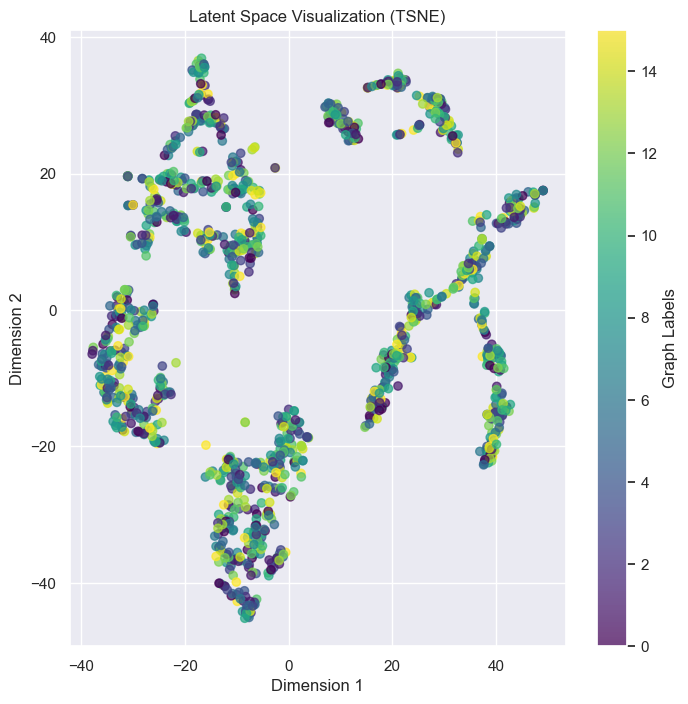

In [120]:
visualize_latent_space(model, train_loader, device=device, method='tsne', perplexity=30)

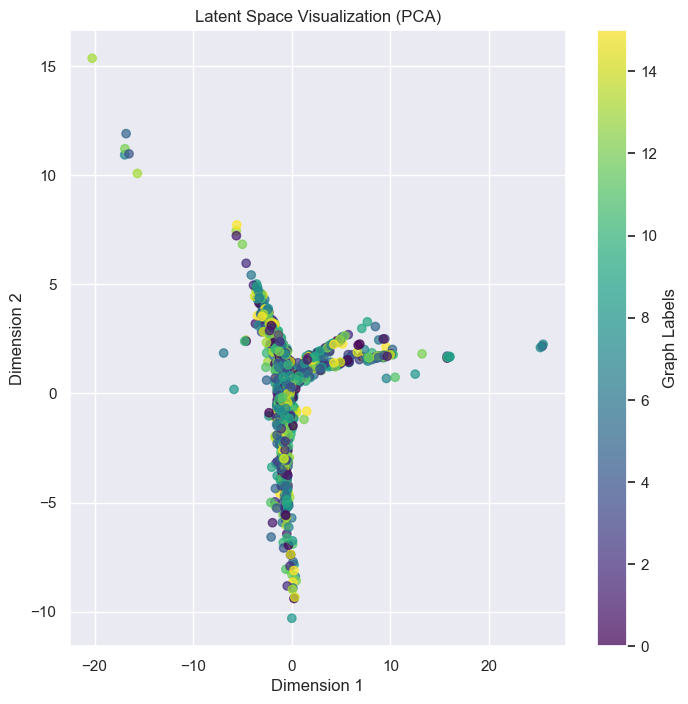

In [121]:
visualize_latent_space(model, train_loader, device=device, method='pca')

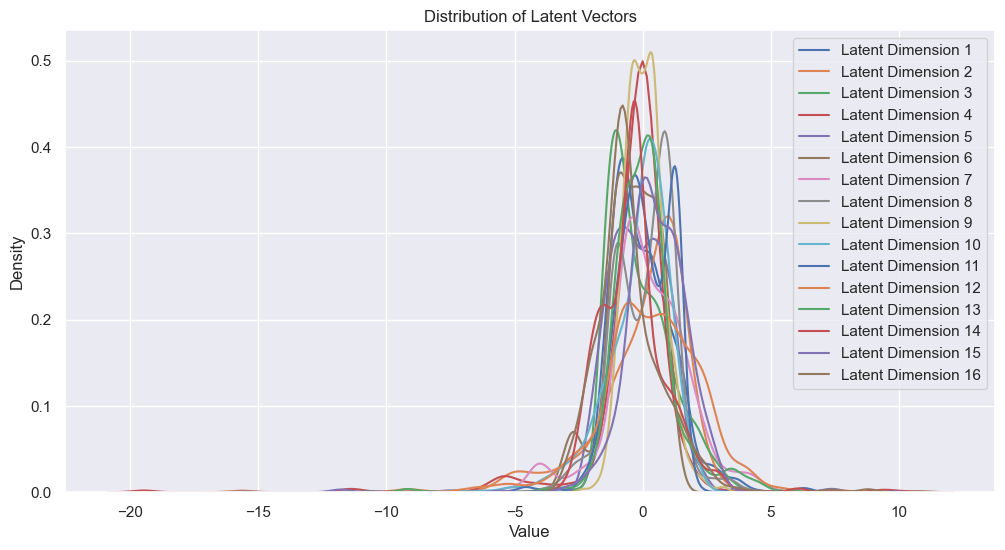

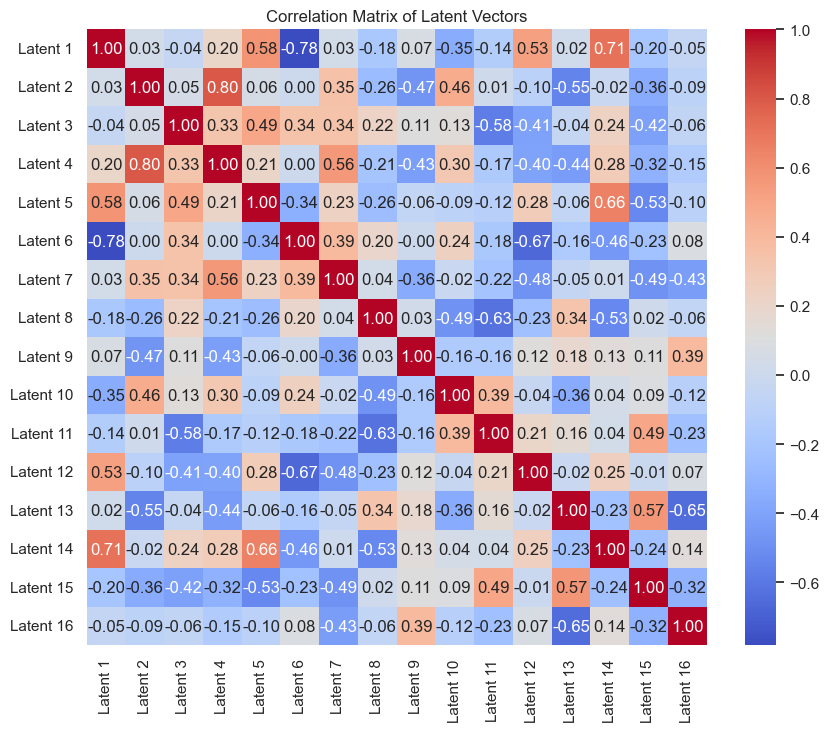

In [122]:
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def plot_latent_distribution_and_correlation(model, data_loader, device):
    """
    Plot the distribution of latent vectors and the correlation matrix.

    Args:
        model: Trained ProteinGraphVAE model.
        data_loader: DataLoader containing the data.
        device: torch device.
    """
    model.eval()
    latent_vectors = []

    with torch.no_grad():
        for batch in data_loader:
            batch = batch.to(device)
            mu, logvar = model.encode(batch.x, batch.edge_index, batch.edge_attr, batch.batch)
            z = model.reparameterize(mu, logvar)
            latent_vectors.append(z.cpu().numpy())

    latent_vectors = np.concatenate(latent_vectors, axis=0)

    # Plot the distribution of latent vectors
    plt.figure(figsize=(12, 6))
    for i in range(latent_vectors.shape[1]):
        sns.kdeplot(latent_vectors[:, i], label=f'Latent Dimension {i+1}')
    plt.title('Distribution of Latent Vectors')
    plt.xlabel('Value')
    plt.ylabel('Density')
    plt.legend()
    plt.show()

    # Compute and plot the correlation matrix
    correlation_matrix = np.corrcoef(latent_vectors, rowvar=False)
    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', 
                xticklabels=[f'Latent {i+1}' for i in range(latent_vectors.shape[1])],
                yticklabels=[f'Latent {i+1}' for i in range(latent_vectors.shape[1])])
    plt.title('Correlation Matrix of Latent Vectors')
    plt.show()

# Example usage
plot_latent_distribution_and_correlation(model, train_loader, device)

In [125]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from scipy.stats import wasserstein_distance

def analyze_latent_space(model, data_loader, device, save_path=None):
    """
    Analyze and visualize the latent space distributions and correlations
    
    Args:
        model: Trained ProteinGraphVAE model
        data_loader: DataLoader containing protein graphs
        device: torch device
        save_path: Optional path to save visualizations
    """
    model.eval()
    latent_vectors = []

    # Collect latent vectors
    with torch.no_grad():
        for batch in data_loader:
            batch = batch.to(device)
            mu, logvar = model.encode(batch.x, batch.edge_index, batch.edge_attr, batch.batch)
            latent_vectors.append(mu.cpu().numpy())

    # Concatenate all latent vectors
    latent_vectors = np.concatenate(latent_vectors, axis=0)

    # Create figure with subplots
    fig = plt.figure(figsize=(20, 10))

    # 1. Distribution plots for each latent dimension
    ax1 = plt.subplot(231)
    for i in range(latent_vectors.shape[1]):
        sns.kdeplot(data=latent_vectors[:, i], ax=ax1, label=f'Dim {i}')
    ax1.set_title('Latent Dimension Distributions')
    ax1.set_xlabel('Value')
    ax1.set_ylabel('Density')
    ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

    # 2. Correlation matrix
    ax2 = plt.subplot(232)
    corr_matrix = np.corrcoef(latent_vectors.T)
    sns.heatmap(corr_matrix,
                ax=ax2,
                cmap='coolwarm',
                center=0,
                vmin=-1,
                vmax=1,
                square=True,
                xticklabels=False,
                yticklabels=False)
    ax2.set_title('Latent Dimension Correlations')

    # 3. PCA visualization
    ax3 = plt.subplot(233)
    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(latent_vectors)
    scatter = ax3.scatter(pca_result[:, 0],
                          pca_result[:, 1],
                          alpha=0.5,
                          c=np.sum(latent_vectors**2, axis=1),  # Color by L2 norm
                          cmap='viridis')
    plt.colorbar(scatter, ax=ax3, label='L2 Norm')
    ax3.set_title(f'PCA Projection\nExplained Variance: {pca.explained_variance_ratio_.sum():.2%}')

    # 4. Box plot of latent dimensions
    ax4 = plt.subplot(234)
    ax4.boxplot(latent_vectors)
    ax4.set_title('Latent Dimension Ranges')
    ax4.set_xlabel('Dimension')
    ax4.set_ylabel('Value')

    # 5. Dimension-wise statistics
    ax5 = plt.subplot(235)
    stats = pd.DataFrame({
        'Mean': np.mean(latent_vectors, axis=0),
        'Std': np.std(latent_vectors, axis=0),
        'Median': np.median(latent_vectors, axis=0),
        'IQR': np.percentile(latent_vectors, 75, axis=0) - np.percentile(latent_vectors, 25, axis=0)
    })
    stats.index = [f'Dim {i}' for i in range(latent_vectors.shape[1])]
    sns.heatmap(stats,
                ax=ax5,
                cmap='viridis',
                annot=True,
                fmt='.2f')
    ax5.set_title('Dimension-wise Statistics')

    # 6. Wasserstein distance matrix between dimensions
    ax6 = plt.subplot(236)
    n_dims = latent_vectors.shape[1]
    wasserstein_mat = np.zeros((n_dims, n_dims))
    for i in range(n_dims):
        for j in range(n_dims):
            wasserstein_mat[i, j] = wasserstein_distance(
                latent_vectors[:, i],
                latent_vectors[:, j]
            )
    sns.heatmap(wasserstein_mat,
                ax=ax6,
                cmap='viridis',
                square=True,
                xticklabels=False,
                yticklabels=False)
    ax6.set_title('Wasserstein Distances\nbetween Dimensions')

    plt.tight_layout()

    # Save if path provided
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')

    # Calculate additional metrics
    metrics = {
        'mean_correlation': np.mean(np.abs(corr_matrix - np.eye(n_dims))),
        'max_correlation': np.max(np.abs(corr_matrix - np.eye(n_dims))),
        'mean_wasserstein': np.mean(wasserstein_mat),
        'dimension_entropy': -np.sum(np.mean(latent_vectors, axis=0) * np.log(np.abs(np.mean(latent_vectors, axis=0)) + 1e-10)),
        'pca_explained_variance': pca.explained_variance_ratio_.sum()
    }

    return fig, metrics

def visualize_latent_traversal(model, data_loader, device, dim_idx=0, n_steps=10):
    """
    Visualize how changing a single latent dimension affects the reconstruction
    
    Args:
        model: Trained ProteinGraphVAE model
        data_loader: DataLoader containing protein graphs
        device: torch device
        dim_idx: Index of dimension to traverse
        n_steps: Number of steps in traversal
    """
    model.eval()

    # Get a sample batch
    batch = next(iter(data_loader)).to(device)

    # Get latent representation
    with torch.no_grad():
        mu, logvar = model.encode(batch.x, batch.edge_index, batch.edge_attr, batch.batch)
        z = model.reparameterize(mu, logvar)

    # Create traversal values
    traversal_range = np.linspace(-3, 3, n_steps)
    reconstructions = []

    # Generate reconstructions
    with torch.no_grad():
        for value in traversal_range:
            z_new = z.clone()
            z_new[:, dim_idx] = value
            recon, edge_recon = model.decode(z_new, batch.x.size(0), batch.edge_index)
            reconstructions.append(recon.cpu().numpy())

    return np.array(reconstructions), traversal_range

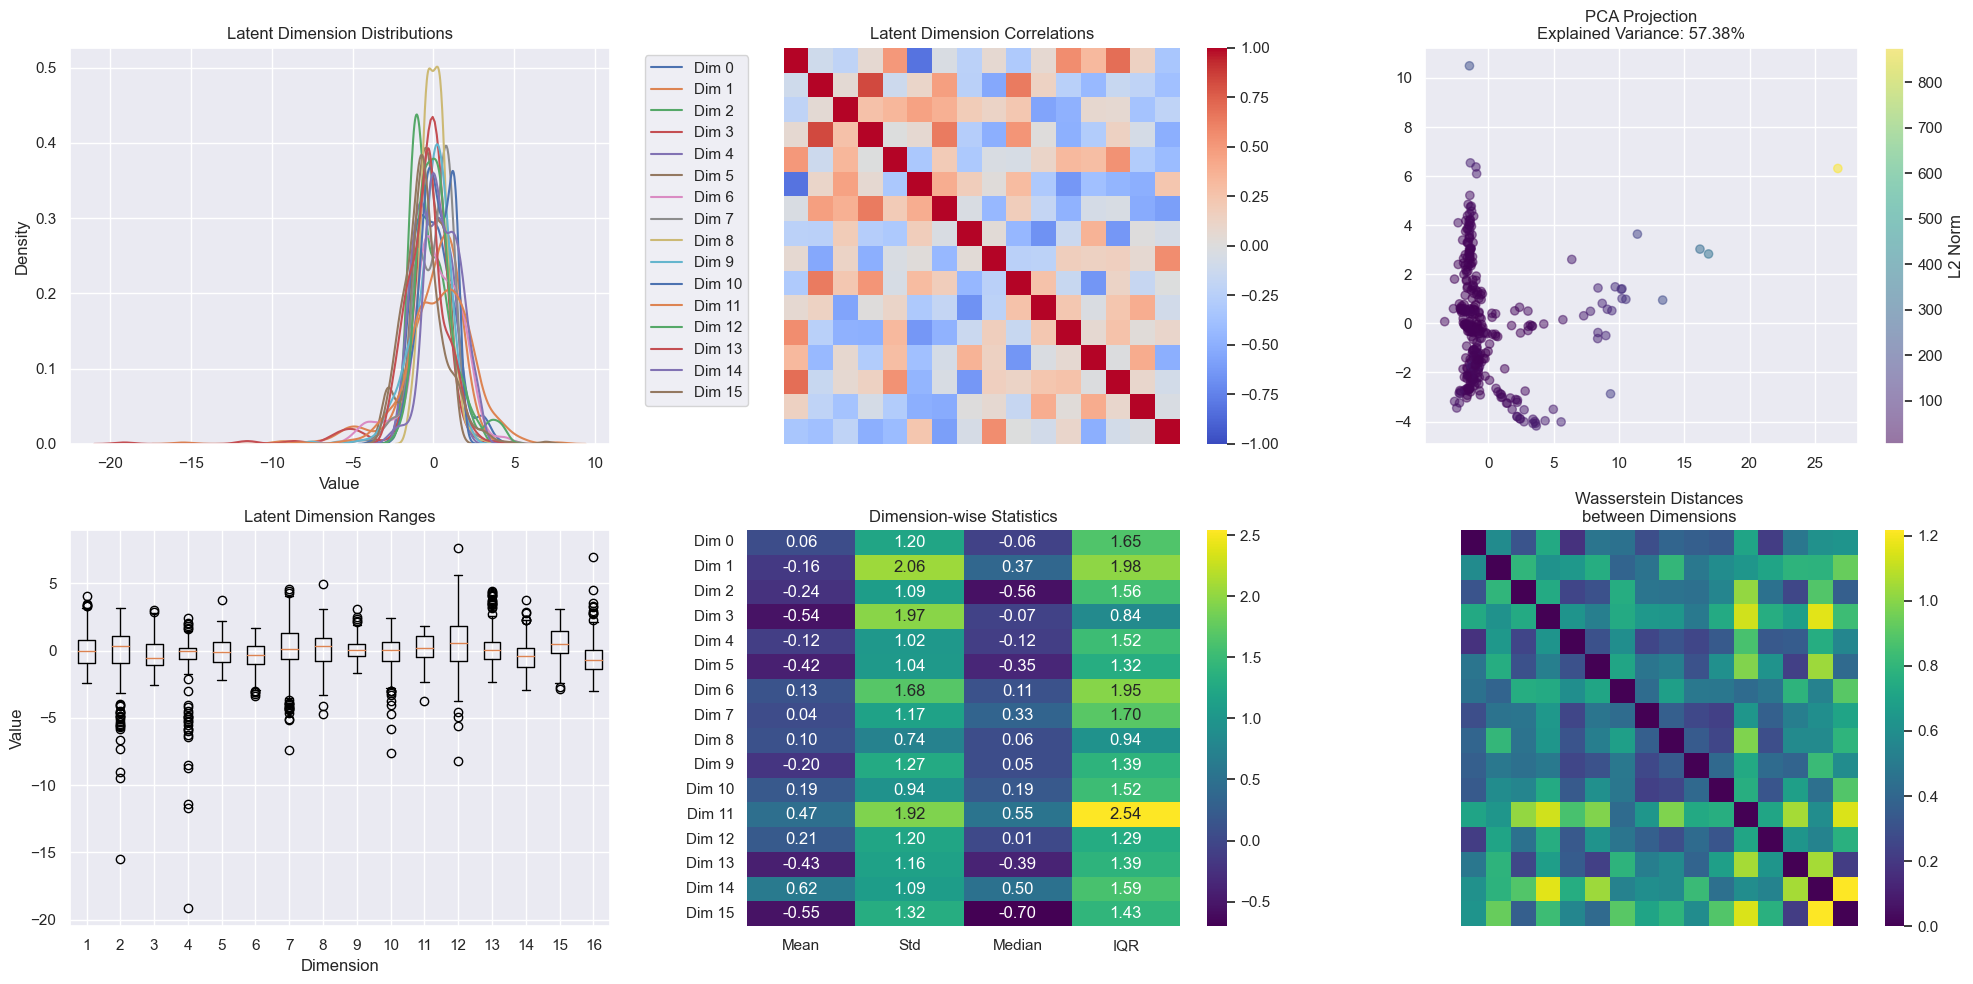

mean_correlation: 0.2573
max_correlation: 0.8303
mean_wasserstein: 0.5472
dimension_entropy: -0.5350
pca_explained_variance: 0.5738


In [126]:
# After training your model
fig, metrics = analyze_latent_space(model, test_loader, device)
plt.show()

# Print latent space metrics
for name, value in metrics.items():
    print(f"{name}: {value:.4f}")

# Visualize how changing dimension 0 affects reconstruction
reconstructions, traversal_values = visualize_latent_traversal(model, test_loader, device, dim_idx=0)

# Generator

In [127]:
import torch
from torch_geometric.data import Data
import numpy as np

def generate_edges_from_coordinates(coords, threshold=5.0):
    """
    Generate edges based on distances between node coordinates.
    """
    edge_index = []
    edge_attr = []

    for i in range(coords.size(0)):
        for j in range(i + 1, coords.size(0)):
            dist = torch.norm(coords[i] - coords[j])
            if dist < threshold:
                edge_index.append([i, j])
                edge_index.append([j, i])
                edge_attr.append([dist.item()])
                edge_attr.append([dist.item()])

    edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()
    edge_attr = torch.tensor(edge_attr, dtype=torch.float)
    return edge_index, edge_attr



In [128]:
def generate_protein_graphs(model, graphs, num_samples=5, nodes_per_graph=200, temperature=1.5):
    """
    Generate new protein graphs with diverse node features.
    """
    # Determine device
    device = 'cuda' if torch.cuda.is_available() else 'cpu'

    # Step 1: Calculate normalization parameters
    feature_means, feature_stds = norm_params
    print(f"Feature means: {feature_means}")
    print(f"Feature stds: {feature_stds}")

    model.eval()
    model = model.to(device)

    generated_graphs = []

    with torch.no_grad():
        # Step 2: Sample diverse latent vectors
        z = torch.randn(num_samples, model.latent_channels, device=device) * temperature
        print("Sampled latent vectors (z):", z)

        # Step 3: Generate graphs
        for i in range(num_samples):
            # Decode latent vector into node features
            z_expanded = z[i].unsqueeze(0).repeat(nodes_per_graph, 1)
            decoded_features, _ = model.decode(z_expanded, num_nodes=nodes_per_graph, edge_index=torch.empty(2, 0, dtype=torch.long, device=device)) # Placeholder edge_index
            print("Decoded features (before unnormalization):", decoded_features)

            # Unnormalize features
            decoded_features = decoded_features * feature_stds.to(device) + feature_means.to(device)

            # Extract coordinates and generate edges
            coords = decoded_features[:, -3:]  # Last three columns are X, Y, Z
            edge_index, edge_attr = generate_edges_from_coordinates(coords, threshold=5.0)
            print("Edge index:", edge_index)
            print("Edge attributes:", edge_attr)

            # Create PyG Data object
            graph = Data(
                x=decoded_features,
                edge_index=edge_index,
                edge_attr=edge_attr
            )

            generated_graphs.append(graph)

    return generated_graphs


In [129]:
# Extract only the graphs from the tuples
graph_data = [g[1] for g in graphs]

# Use the extracted graphs to generate proteins
generated_proteins = generate_protein_graphs(
    model=model,
    graphs=graph_data,  # Pass only the graphs
    num_samples=5,
    nodes_per_graph=200,
    temperature=1.5
)

Feature means: tensor([-2.2879e-09, -4.5757e-10,  3.4494e-09, -1.2249e-08,  1.7266e-09,
         5.6735e-09,  7.4301e-09,  3.4648e-09])
Feature stds: tensor([1., 1., 1., 1., 1., 1., 1., 1.])
Sampled latent vectors (z): tensor([[ 1.5856, -0.5415,  1.1701, -0.3341, -0.5312, -0.5779,  1.7728, -1.0730,
          1.6733, -1.4520, -2.9737,  2.8823, -1.5549, -3.0704, -2.3911,  1.8415],
        [ 0.9171, -0.5796, -0.2660, -0.2807,  1.8461, -1.5301,  1.2790, -0.0111,
         -1.5476, -2.8773, -1.5780, -1.6077, -1.0441, -0.7059, -2.6657,  1.1339],
        [ 0.7333, -1.3184, -1.6685, -0.4911,  0.0650, -3.3510,  1.9186,  1.9616,
          0.5927,  0.1834, -0.8897, -0.0397, -1.5430, -0.8386,  2.4434,  1.2942],
        [-0.6819,  0.1547,  2.5525, -0.9059, -2.1799, -1.9768, -2.9925, -4.2083,
         -1.4305,  0.5446, -1.8147,  0.7186, -0.9084, -1.5841,  0.2441,  1.0229],
        [ 1.4759, -0.5404, -0.2946,  0.2942, -0.3488,  2.4190,  1.2531,  1.4392,
          0.9615, -1.1902, -2.7757,  0.9875, -1.

In [130]:
# Analyze the generated graphs
for i, protein in enumerate(generated_proteins):
    print(f"Protein {i+1}:")
    print(f"  Number of nodes: {protein.x.size(0)}")
    print(f"  Number of edges: {protein.edge_index.size(1)}")
    print(f"  Feature mean: {protein.x.mean(dim=0)}")
    print(f"  Feature std: {protein.x.std(dim=0)}")


Protein 1:
  Number of nodes: 200
  Number of edges: 39800
  Feature mean: tensor([[ 0.0032,  0.0020,  0.0014,  ..., -0.0803, -0.0183, -0.1186],
        [ 0.0032,  0.0020,  0.0014,  ..., -0.0800, -0.0183, -0.1181],
        [ 0.0032,  0.0020,  0.0014,  ..., -0.0797, -0.0182, -0.1176],
        ...,
        [ 0.0032,  0.0020,  0.0014,  ..., -0.0797, -0.0182, -0.1174],
        [ 0.0032,  0.0020,  0.0014,  ..., -0.0798, -0.0182, -0.1183],
        [ 0.0032,  0.0020,  0.0014,  ..., -0.0798, -0.0181, -0.1183]])
  Feature std: tensor([[1.3669e-05, 4.6841e-06, 2.8959e-06,  ..., 3.2997e-03, 2.0519e-03,
         5.5100e-03],
        [1.3593e-05, 4.6525e-06, 3.2556e-06,  ..., 3.4190e-03, 2.2815e-03,
         5.7998e-03],
        [1.4246e-05, 4.5902e-06, 3.3527e-06,  ..., 3.5021e-03, 2.2747e-03,
         6.1962e-03],
        ...,
        [1.3022e-05, 4.6610e-06, 3.3209e-06,  ..., 3.1046e-03, 1.9989e-03,
         5.8078e-03],
        [1.2986e-05, 4.2357e-06, 2.9917e-06,  ..., 3.2495e-03, 2.1453e-03,


(test latest version)

In [131]:
import torch
import numpy as np
from torch_geometric.data import Data
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from torch_geometric.data import Data

def generate_protein_graphs(model, norm_params, num_samples=1, nodes_per_graph=100, temperature=1.0):
    """Generate new protein graphs with diverse node features"""
    # Determine device
    device = 'cuda' if torch.cuda.is_available() else 'cpu'

    feature_means, feature_stds = norm_params  # Unpack normalization parameters
    model.eval()
    model = model.to(device)

    generated_graphs = []

    with torch.no_grad():
        # Sample from normal distribution
        z = torch.randn(num_samples, model.latent_channels, device=device) * temperature

        # Add node-specific variations
        z = z.unsqueeze(1).repeat(1, nodes_per_graph, 1)
        node_noise = torch.randn_like(z) * 0.1
        z = z + node_noise

        # Reshape for decoder
        z = z.view(-1, model.latent_channels)

        # Create initial dummy edge_index for decoding
        edge_index = torch.arange(nodes_per_graph * num_samples, device=device)
        edge_index = edge_index.repeat(2, 1)  # [2, num_nodes]

        # Decode the latent vectors
        decoded, _ = model.decode(z, nodes_per_graph, edge_index)

        # Unnormalize the features
        decoded = decoded * feature_stds.to(device) + feature_means.to(device)


        # Process each generated graph
        for i in range(num_samples):
            # Extract features for this graph
            start_idx = i * nodes_per_graph
            end_idx = (i + 1) * nodes_per_graph
            features = decoded[i]  # Get features for this graph

            # Generate edges based on coordinates
            coords = features[..., -3:]
            edge_index = []
            edge_attr = []

            for j in range(len(coords)):
                for k in range(j + 1, len(coords)):
                    dist = torch.norm(coords[j] - coords[k])
                    if dist < 5.0:  # Threshold for edge creation
                        edge_index.extend([[j, k], [k, j]])
                        edge_attr.extend([dist.item(), dist.item()])

            if len(edge_index) > 0:
                edge_index = torch.tensor(edge_index, dtype=torch.long).t()
                edge_attr = torch.tensor(edge_attr).unsqueeze(1)
            else:
                # Fallback: connect nearest neighbors if no edges were created
                dists = torch.cdist(coords, coords)
                k = 3  # Connect to k nearest neighbors
                _, indices = torch.topk(-dists, k + 1)  # Negative for closest

                edge_index = []
                edge_attr = []
                for j in range(len(coords)):
                    for idx in indices[j][1:]:  # Skip self
                        edge_index.extend([[j, idx.item()], [idx.item(), j]])
                        dist = dists[j, idx].item()
                        edge_attr.extend([dist, dist])

                edge_index = torch.tensor(edge_index, dtype=torch.long).t()
                edge_attr = torch.tensor(edge_attr).unsqueeze(1)

            # Create graph
            graph = Data(
                x=features,
                edge_index=edge_index,
                edge_attr=edge_attr
            )

            generated_graphs.append(graph)

    return generated_graphs


def interpolate_proteins(model, protein1, protein2, num_steps=10, device='cuda'):
    """
    Generate interpolated proteins between two existing proteins
    """
    model.eval()
    model = model.to(device)

    # Convert proteins to batches
    batch1 = torch.zeros(protein1.x.size(0), dtype=torch.long)
    batch2 = torch.zeros(protein2.x.size(0), dtype=torch.long)

    # Get latent representations
    with torch.no_grad():
        protein1 = protein1.to(device)
        protein2 = protein2.to(device)

        mu1, _ = model.encode(protein1.x, protein1.edge_index, protein1.edge_attr, batch1)
        mu2, _ = model.encode(protein2.x, protein2.edge_index, protein2.edge_attr, batch2)

        # Interpolate in latent space
        interpolated_graphs = []
        alphas = np.linspace(0, 1, num_steps)

        max_nodes = max(protein1.x.size(0), protein2.x.size(0))

        for alpha in alphas:
            # Interpolate latent vectors
            z = (1 - alpha) * mu1 + alpha * mu2

            # Create initial dummy edge_index for decoding
            edge_index = torch.arange(max_nodes, device=device)
            edge_index = edge_index.repeat(2, 1)  # [2, num_nodes]

            # Decode
            decoded, _ = model.decode(z.unsqueeze(0), max_nodes, edge_index)
            decoded = decoded[0]

            # Process decoded features
            coords = decoded[:, -3:]

            # Generate edges based on distances
            edge_index = []
            edge_attr = []

            for i in range(len(coords)):
                for j in range(i + 1, len(coords)):
                    dist = torch.norm(coords[i] - coords[j])
                    if dist < 5.0:
                        edge_index.extend([[i, j], [j, i]])
                        edge_attr.extend([dist.item(), dist.item()])

            if len(edge_index) > 0:
                edge_index = torch.tensor(edge_index, dtype=torch.long).t()
                edge_attr = torch.tensor(edge_attr).unsqueeze(1)
            else:
                edge_index = torch.arange(len(coords)).repeat(2, 1)
                edge_attr = torch.ones(len(coords), 1)

            # Create graph
            graph = Data(
                x=decoded,
                edge_index=edge_index,
                edge_attr=edge_attr
            )

            interpolated_graphs.append(graph)

    return interpolated_graphs
def visualize_protein_graph(graph, title="Generated Protein Structure"):
    """Improved visualization of protein graph"""
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')

    # Get coordinates
    coords = graph.x[:, -3:].cpu().numpy()
    masses = graph.x[:, 0].cpu().numpy()  # Use mass for point size
    small_mols = graph.x[:, 4].cpu().numpy()  # Use for coloring

    # Scale masses for visualization
    sizes = 50 + (masses - masses.min()) / (masses.max() - masses.min()) * 100

    # Plot nodes with size based on mass and color based on small molecules
    scatter = ax.scatter(coords[:, 0], coords[:, 1], coords[:, 2],
                         c=small_mols, cmap='coolwarm',
                         s=sizes, alpha=0.6)

    # Plot edges
    edges = graph.edge_index.cpu().numpy()
    for i in range(0, edges.shape[1], 2):
        start = coords[edges[0, i]]
        end = coords[edges[1, i]]
        ax.plot([start[0], end[0]],
                [start[1], end[1]],
                [start[2], end[2]], 'gray', alpha=0.2)

    plt.colorbar(scatter, label='Small Molecules')
    ax.set_title(title)

    # Set equal aspect ratio
    ax.set_box_aspect([1,1,1])

    plt.show()


# Example usage:
def generate_and_visualize_proteins(model, device='cuda'):
    """
    Generate and visualize some example proteins
    """
    # Generate new proteins
    print("Generating new proteins...")
    generated = generate_protein_graphs(model, num_samples=3, nodes_per_graph=100, device=device)

    # Visualize each generated protein
    for i, graph in enumerate(generated):
        visualize_protein_graph(graph, f"Generated Protein {i+1}")

    return generated

def interpolate_and_visualize(model, protein1, protein2, device='cuda'):
    """
    Interpolate between two proteins and visualize the results
    """
    print("Generating interpolated proteins...")
    interpolated = interpolate_proteins(model, protein1, protein2, num_steps=5, device=device)

    # Visualize interpolation
    for i, graph in enumerate(interpolated):
        visualize_protein_graph(graph, f"Interpolation Step {i+1}")

    return interpolated

def print_graph_info(graph, title="Graph Info", num_samples=5):
    print(f"\n{title}")
    print(f"Node features shape: {graph.x.shape}")
    print(f"Edge index shape: {graph.edge_index.shape}")

    # Print feature statistics
    print("\nFeature statistics:")
    print(f"Mass range: {graph.x[:, 0].min().item():.2f} to {graph.x[:, 0].max().item():.2f}")
    print(f"Avg Neighbor Dist range: {graph.x[:, 1].min().item():.2f} to {graph.x[:, 1].max().item():.2f}")
    print(f"Max Neighbor Dist range: {graph.x[:, 2].min().item():.2f} to {graph.x[:, 2].max().item():.2f}")
    print(f"Neighbor Count range: {graph.x[:, 3].min().item():.2f} to {graph.x[:, 3].max().item():.2f}")
    print(f"Small Molecules ratio: {graph.x[:, 4].mean().item():.2f}")

    print("\nSample nodes:")
    for i in range(min(num_samples, len(graph.x))):
        features = graph.x[i]
        print(f"\nNode {i}:")
        print(f"  Mass: {features[0].item():.2f}")
        print(f"  Avg/Max Neighbor Dist: {features[1].item():.2f}/{features[2].item():.2f}")
        print(f"  Neighbor Count: {features[3].item():.0f}")
        print(f"  Small Molecules: {features[4].item():.0f}")
        print(f"  Coordinates: ({features[5].item():.2f}, {features[6].item():.2f}, {features[7].item():.2f})")


In [132]:
generated_proteins = generate_protein_graphs(
    model=model,               # The trained model
    norm_params=norm_params,   # Use normalization parameters from preprocessing
    num_samples=3,             # Number of proteins to generate
    nodes_per_graph=100,       # Number of nodes per generated graph
    temperature=1.0            # Sampling diversity
)

In [133]:
def map_mass_to_color(mass_value):
    """Map a mass value to the closest amino acid color."""
    # Scale the negative values around -9.76 to the amino acid mass range
    scaled_mass = (abs(mass_value) + 1) * 20  # This should map to 75-255 range

    print(f"Original mass: {mass_value}, Scaled mass: {scaled_mass}")
    closest_aa = min(AMINO_ACID_DATA,
                     key=lambda x: abs(x[0] - scaled_mass))
    return closest_aa[2]

def visualize_generated_protein_graph(data, title="Generated Protein Graph"):
    # First create the initial graph with all attributes
    original_G = to_networkx(data, edge_attrs=['edge_attr'], node_attrs=['x'])

    # Store node attributes before filtering
    node_attrs = {node: attrs['x'] for node, attrs in original_G.nodes(data=True)}

    # Create filtered graph while preserving node attributes
    edge_threshold = 0.003
    G = nx.Graph((u, v, d) for u, v, d in original_G.edges(data=True)
                 if float(d['edge_attr'][0]) > edge_threshold)

    # Add back node attributes
    nx.set_node_attributes(G, {node: {'x': attrs} for node, attrs in node_attrs.items()})

    pos = nx.spring_layout(G, k=2.0, iterations=100, seed=42)

    node_colors = [map_mass_to_color(node_attrs[node][4]) for node in G.nodes()]
    node_sizes = [max(300, abs(float(node_attrs[node][5]) * 2000)) for node in G.nodes()]

    edge_weights = [
        max(0.1, min(1.0, float(edge[2]['edge_attr'][0]) * 50))
        for edge in G.edges(data=True)
    ]

    plt.figure(figsize=(12, 12))

    nx.draw(
        G,
        pos,
        node_color=node_colors,
        node_size=node_sizes,
        edge_color='gray',
        width=edge_weights,
        alpha=0.7,
        with_labels=False
    )

    # Add legend
    legend_elements = [plt.Line2D([0], [0], marker='o', color='w',
                                  markerfacecolor=color, label=name, markersize=10)
                       for mass, name, color in AMINO_ACID_DATA]
    plt.legend(handles=legend_elements, loc='center left',
               bbox_to_anchor=(1, 0.5), title="Amino Acids")

    plt.title(title)
    plt.tight_layout()
    plt.show()

Original mass: -3.697474956512451, Scaled mass: 93.94949913024902
Original mass: -3.659734010696411, Scaled mass: 93.19468021392822
Original mass: -3.7123665809631348, Scaled mass: 94.2473316192627
Original mass: -3.640507936477661, Scaled mass: 92.81015872955322
Original mass: -3.739020824432373, Scaled mass: 94.78041648864746
Original mass: -3.6714444160461426, Scaled mass: 93.42888832092285
Original mass: -3.6677417755126953, Scaled mass: 93.3548355102539
Original mass: -3.647021770477295, Scaled mass: 92.9404354095459
Original mass: -3.6234583854675293, Scaled mass: 92.46916770935059
Original mass: -3.661288022994995, Scaled mass: 93.2257604598999
Original mass: -3.591615676879883, Scaled mass: 91.83231353759766
Original mass: -3.588247060775757, Scaled mass: 91.76494121551514
Original mass: -3.6472296714782715, Scaled mass: 92.94459342956543
Original mass: -3.6666157245635986, Scaled mass: 93.33231449127197
Original mass: -3.6425652503967285, Scaled mass: 92.85130500793457
Origina

/var/folders/lp/38fnv8v91rqdkwbf17xlnxyh0000gn/T/ipykernel_91343/40893172.py:57: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


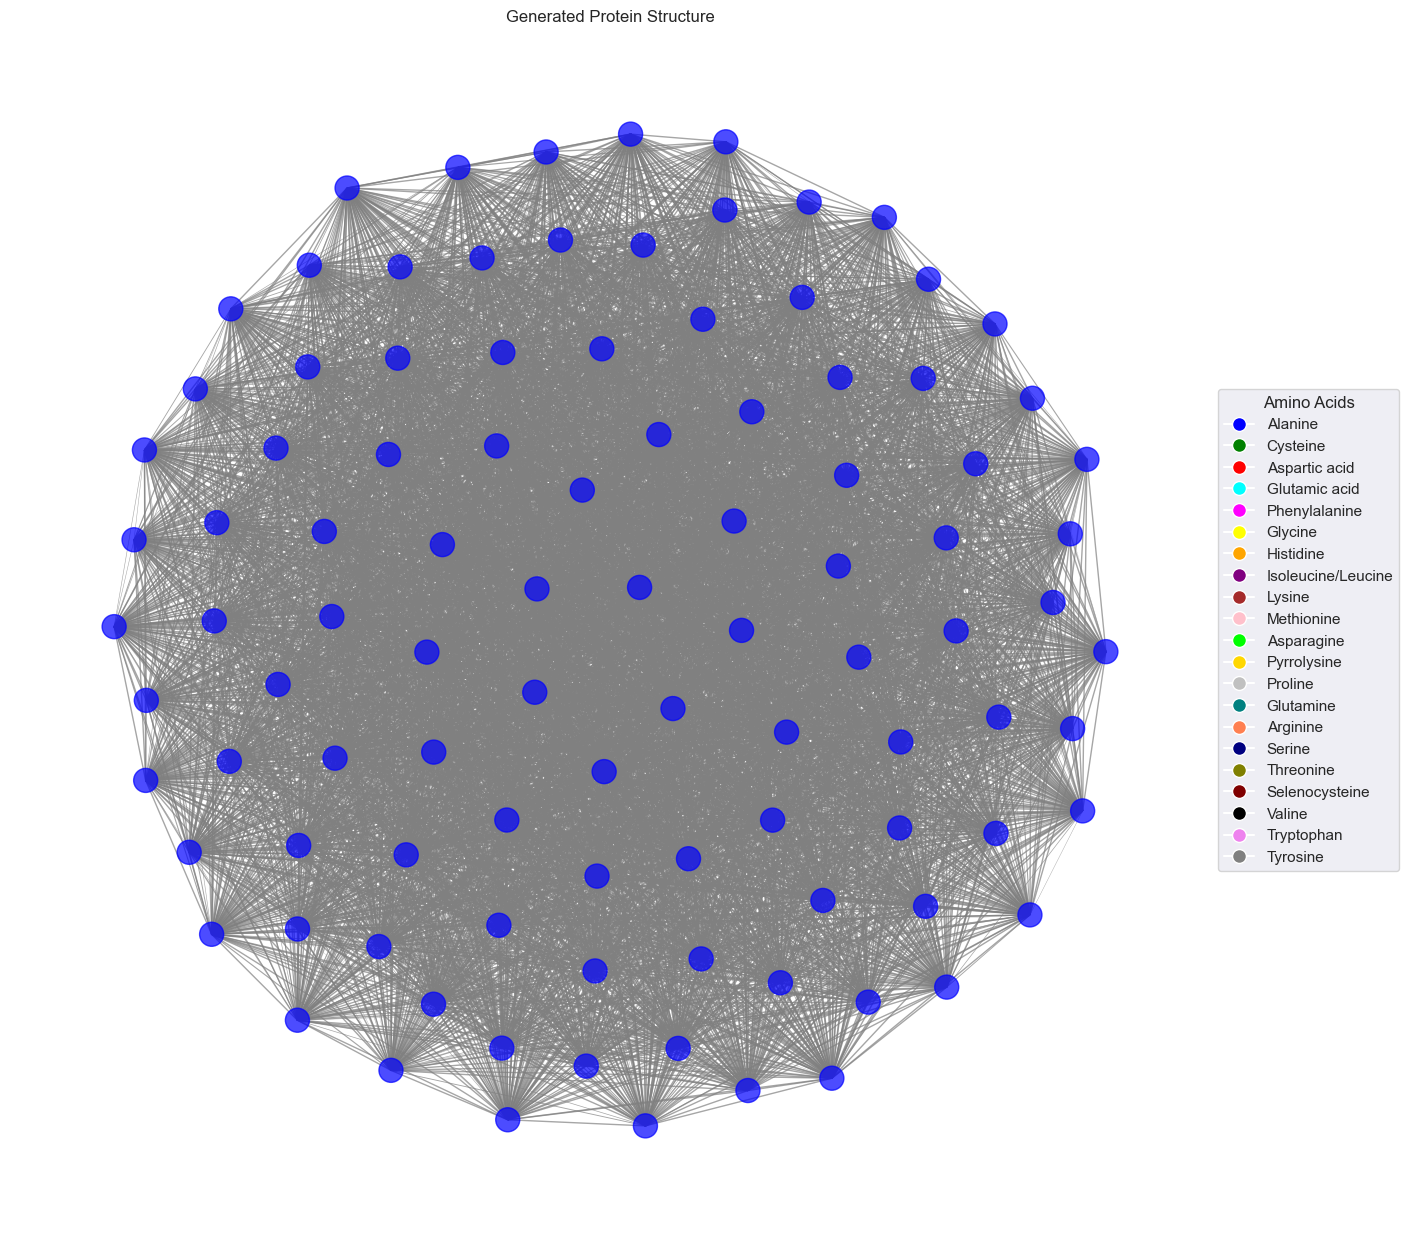

In [134]:
generated_protein = generated_proteins[0]  # Assume you have generated graphs
visualize_generated_protein_graph(generated_protein, title="Generated Protein Structure")


In [89]:
generated_proteins[0]

Data(x=[100, 8], edge_index=[2, 9900], edge_attr=[9900, 1])

In [90]:
generated_proteins[1]

Data(x=[100, 8], edge_index=[2, 9900], edge_attr=[9900, 1])

New generator: 

In [91]:
def generate_protein_graphs(model, norm_params, num_samples=3, nodes_per_graph=100, temperature=1.0):
    """Generate new protein graphs with diverse node features"""
    # Determine device
    device = 'cuda' if torch.cuda.is_available() else 'cpu'

    feature_means, feature_stds = norm_params  # Unpack normalization parameters
    model.eval()
    model = model.to(device)

    generated_graphs = []

    with torch.no_grad():
        # Sample diverse latent vectors
        z = torch.randn(num_samples, model.latent_channels, device=device) * temperature

        # Add small random noise for variability
        z = z + torch.randn_like(z) * 0.1

        for i in range(num_samples):
            # Expand latent vector for all nodes
            z_expanded = z[i].unsqueeze(0).repeat(nodes_per_graph, 1)

            # Decode latent vectors into node features
            decoded_features, _ = model.decode(z_expanded, nodes_per_graph, edge_index=None)

            # Unnormalize features
            decoded_features = decoded_features * feature_stds.to(device) + feature_means.to(device)

            # Generate edges based on spatial coordinates (decoded)
            coords = decoded_features[:, -3:]  # Extract X, Y, Z
            edge_index, edge_attr = generate_edges_from_coordinates(coords, threshold=5.0)

            # Create PyG Data object
            graph = Data(
                x=decoded_features,
                edge_index=edge_index,
                edge_attr=edge_attr
            )

            generated_graphs.append(graph)

    return generated_graphs


def generate_edges_from_coordinates(coords, threshold=5.0):
    """Generate edges based on distances between coordinates"""
    edge_index = []
    edge_attr = []

    for i in range(coords.size(0)):
        for j in range(i + 1, coords.size(0)):
            dist = torch.norm(coords[i] - coords[j])
            if dist < threshold:
                edge_index.append([i, j])
                edge_index.append([j, i])
                edge_attr.append([dist.item()])
                edge_attr.append([dist.item()])

    edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()
    edge_attr = torch.tensor(edge_attr, dtype=torch.float)

    return edge_index, edge_attr


In [103]:
generated_proteins = generate_protein_graphs(
    model=model,
    norm_params=(, feature_stds),
    num_samples=3,
    nodes_per_graph=100,
    temperature=1.0
)

# Check if graphs are diverse
for i, graph in enumerate(generated_proteins):
    print(f"Graph {i}: Node Features Mean: {graph.x.mean(dim=0)}, Std: {graph.x.std(dim=0)}")


NameError: name 'feature_means' is not defined